<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/causal_method/unified_approach/4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 - Clustering process and validation



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering

df_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/df_ma.csv"
df_pca_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/unified_approach/df_reduced.csv"

numerical_features = ['LIT_HC', 'LIT_HP', 'N_ETB',
'N_UFS', 'PN_MEDICAL', 'POPULATION',
'P_MEDICAL', 'QUANTITY', 'QUANTITY_MA',
'SEJ_HAD', 'SEJ_MCO', 'SEJ_PSY',
'SEJ_SLD', 'SEJ_SSR']

df = pd.read_csv(df_url)
df_pca = pd.read_csv(df_pca_url)

# Convert numerical columns to string
for i, curr_df in enumerate([df]):
    numerical_columns = ['HOSPI_CODE_UCD']
    curr_df[numerical_columns] = curr_df[numerical_columns].astype('string')

df['DATE'] = pd.to_datetime(df['DATE'],
              format='%Y-%m')  # Changed the type of date too

medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [ ]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6320 entries, 0 to 6319
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC01    6320 non-null   float64
 1   PC02    6320 non-null   float64
 2   PC03    6320 non-null   float64
 3   PC04    6320 non-null   float64
 4   PC05    6320 non-null   float64
 5   PC06    6320 non-null   float64
 6   PC07    6320 non-null   float64
 7   PC08    6320 non-null   float64
 8   PC09    6320 non-null   float64
 9   PC10    6320 non-null   float64
 10  PC11    6320 non-null   float64
 11  PC12    6320 non-null   float64
 12  PC13    6320 non-null   float64
 13  PC14    6320 non-null   float64
 14  PC15    6320 non-null   float64
 15  PC16    6320 non-null   float64
 16  PC17    6320 non-null   float64
 17  PC18    6320 non-null   float64
 18  PC19    6320 non-null   float64
 19  PC20    6320 non-null   float64
dtypes: float64(20)
memory usage: 987.6 KB


In [ ]:
def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()

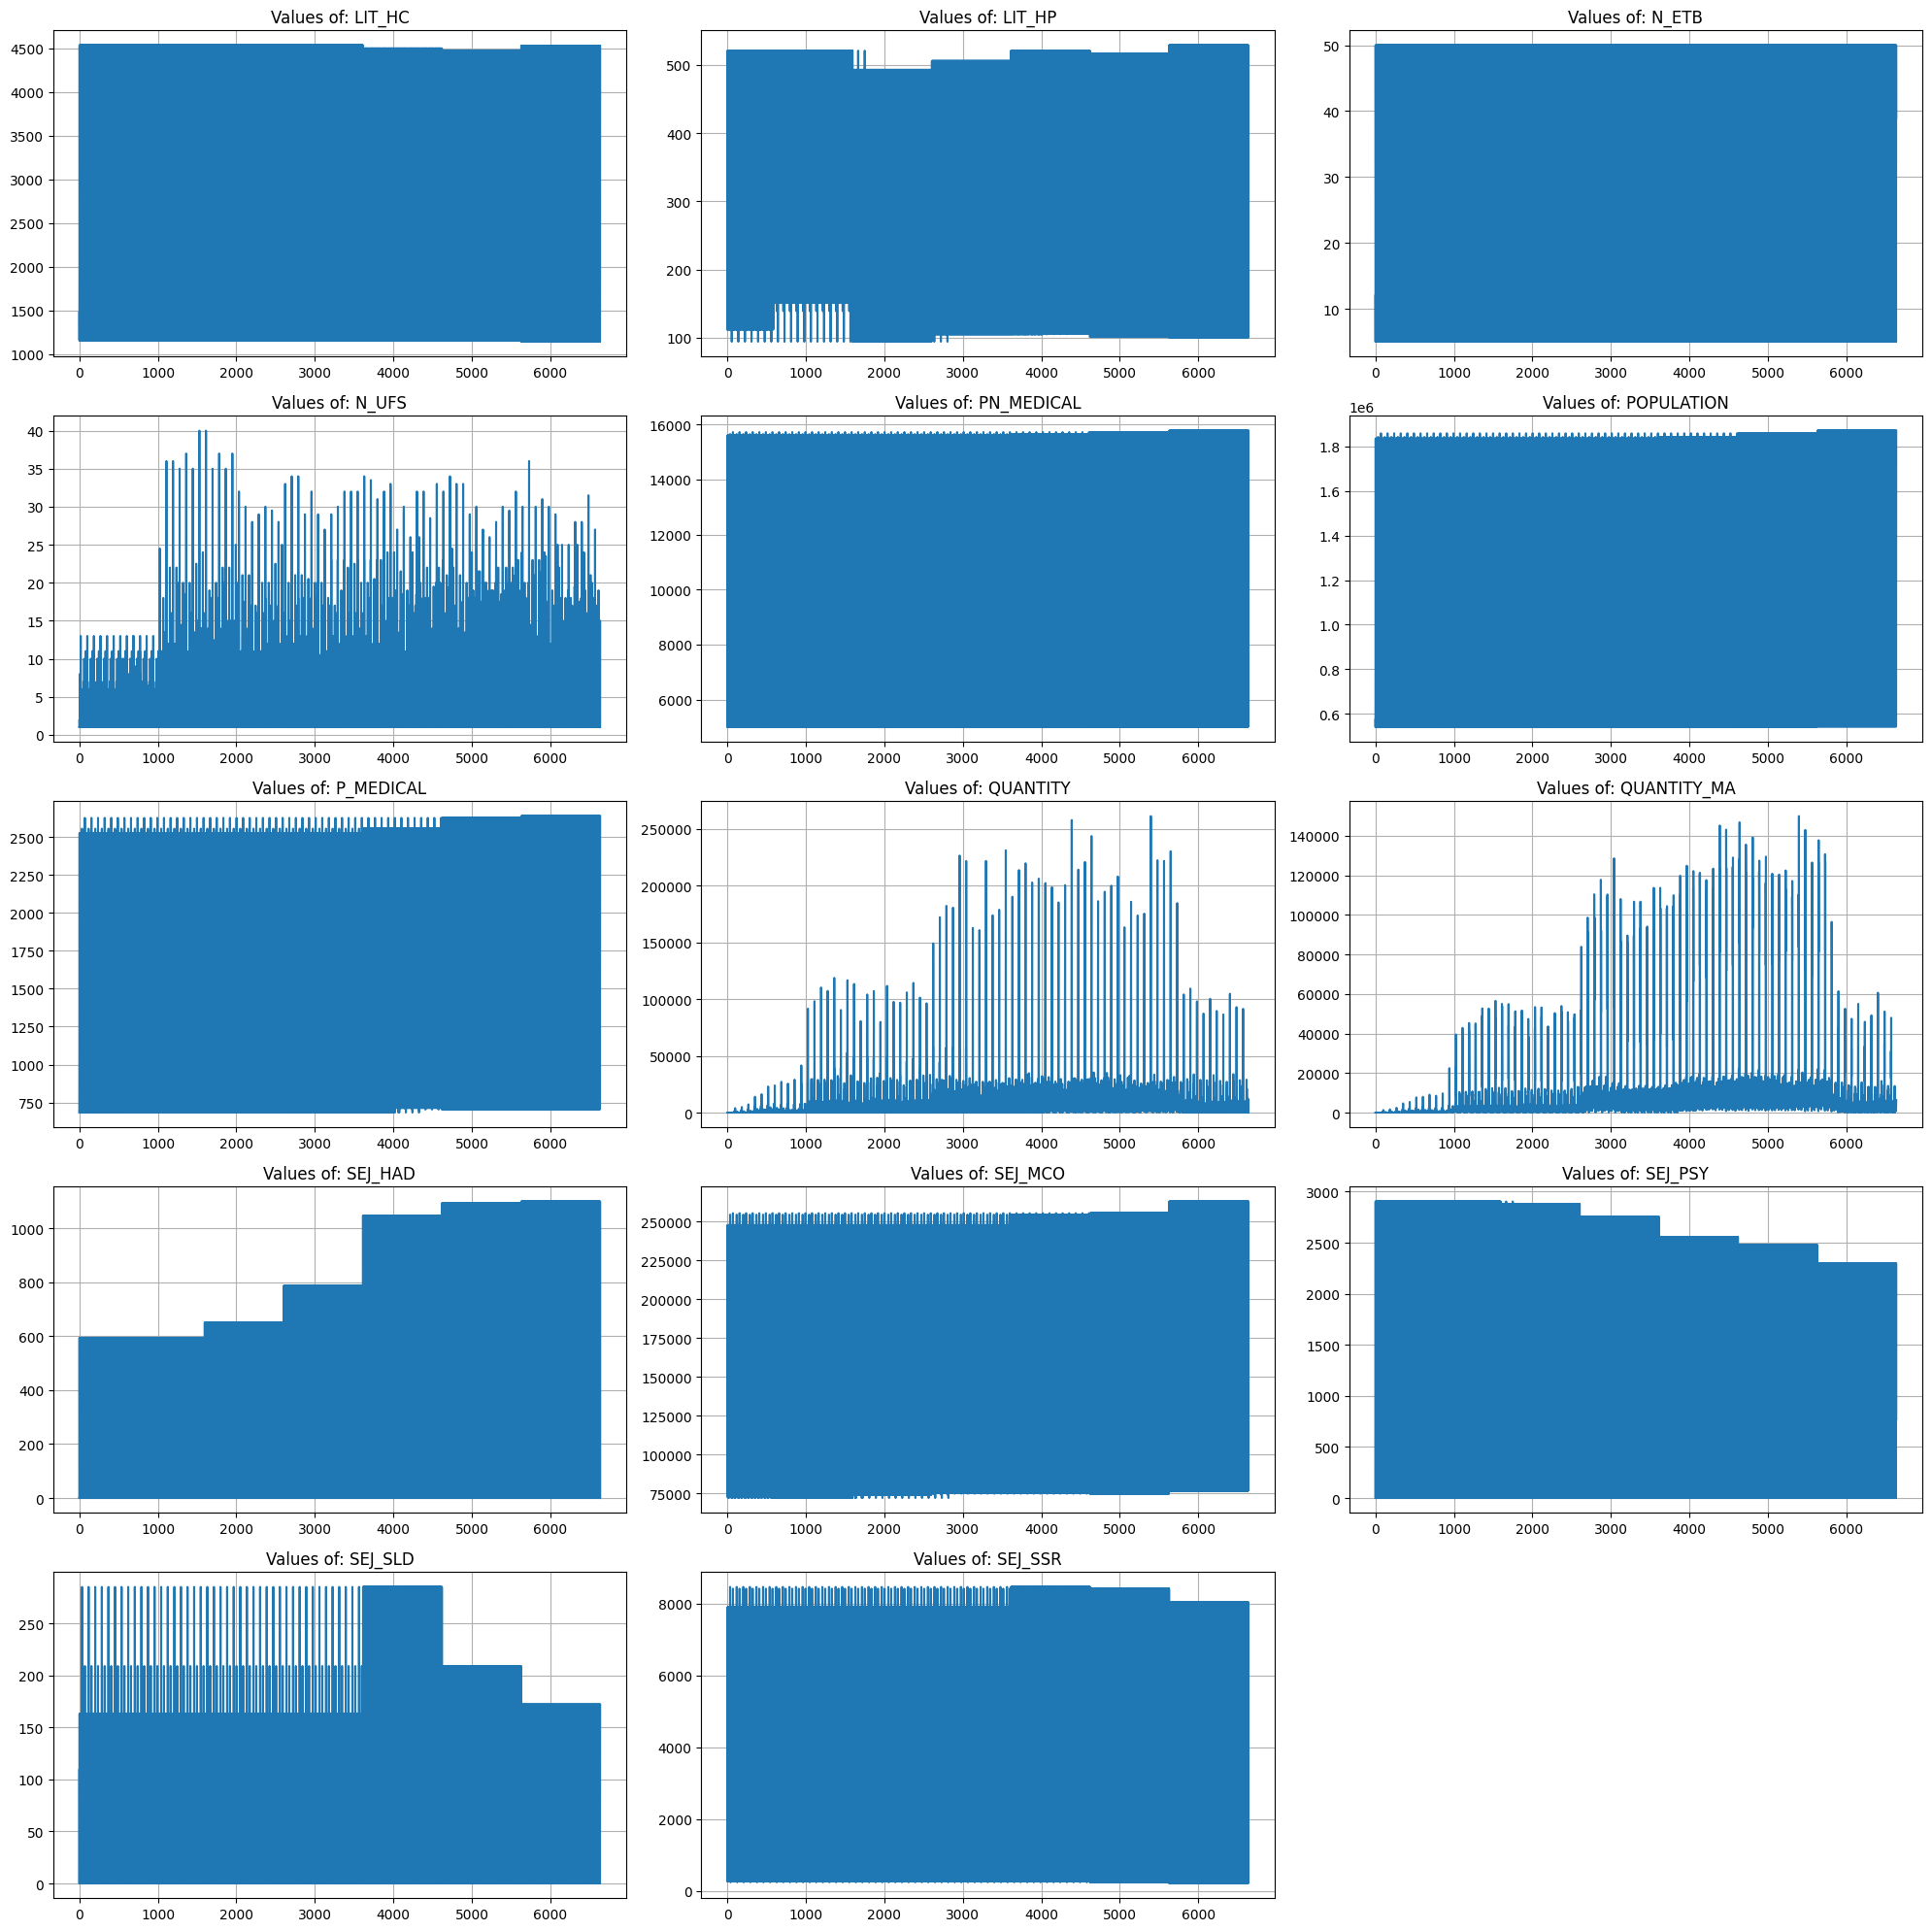

In [ ]:
plot_df(df[numerical_features].copy(), n_cols=3)

In [ ]:
def visualize_distribution(df, data_type='numerical', n_cols=3):
    if data_type == 'numerical':
        columns = df.select_dtypes(include=[int, float]).columns
    elif data_type == 'categorical':
        columns = df.select_dtypes(include=[object, 'string']).columns
    else:
        raise ValueError("Invalid data_type parameter. Supported values: 'numerical', 'categorical'")

    if len(columns) == 0:
        raise ValueError("No columns of the specified data type found in the DataFrame.")

    num_features = len(columns)
    n_rows = m.ceil(num_features / n_cols)

    # Handle the case when n_rows or n_cols is 1
    if n_rows == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 10))
        axes = [axes]  # Wrap the single axis in a list
    elif n_cols == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(10, 20))
        axes = [[ax] for ax in axes]  # Convert each axis to a list
    else:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    # Set a predefined color palette
    palette = sns.color_palette("Set3", n_colors=num_features)

    for i, column in enumerate(columns):
        ax = axes[i // n_cols][i % n_cols]  # Access the axis correctly
        if data_type == 'numerical':
            sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        elif data_type == 'categorical':
            sns.countplot(x=column, data=df, ax=ax, palette=[palette[i]])
            ax.tick_params(axis='x', rotation=45)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols][i % n_cols])

    plt.tight_layout()
    plt.show()

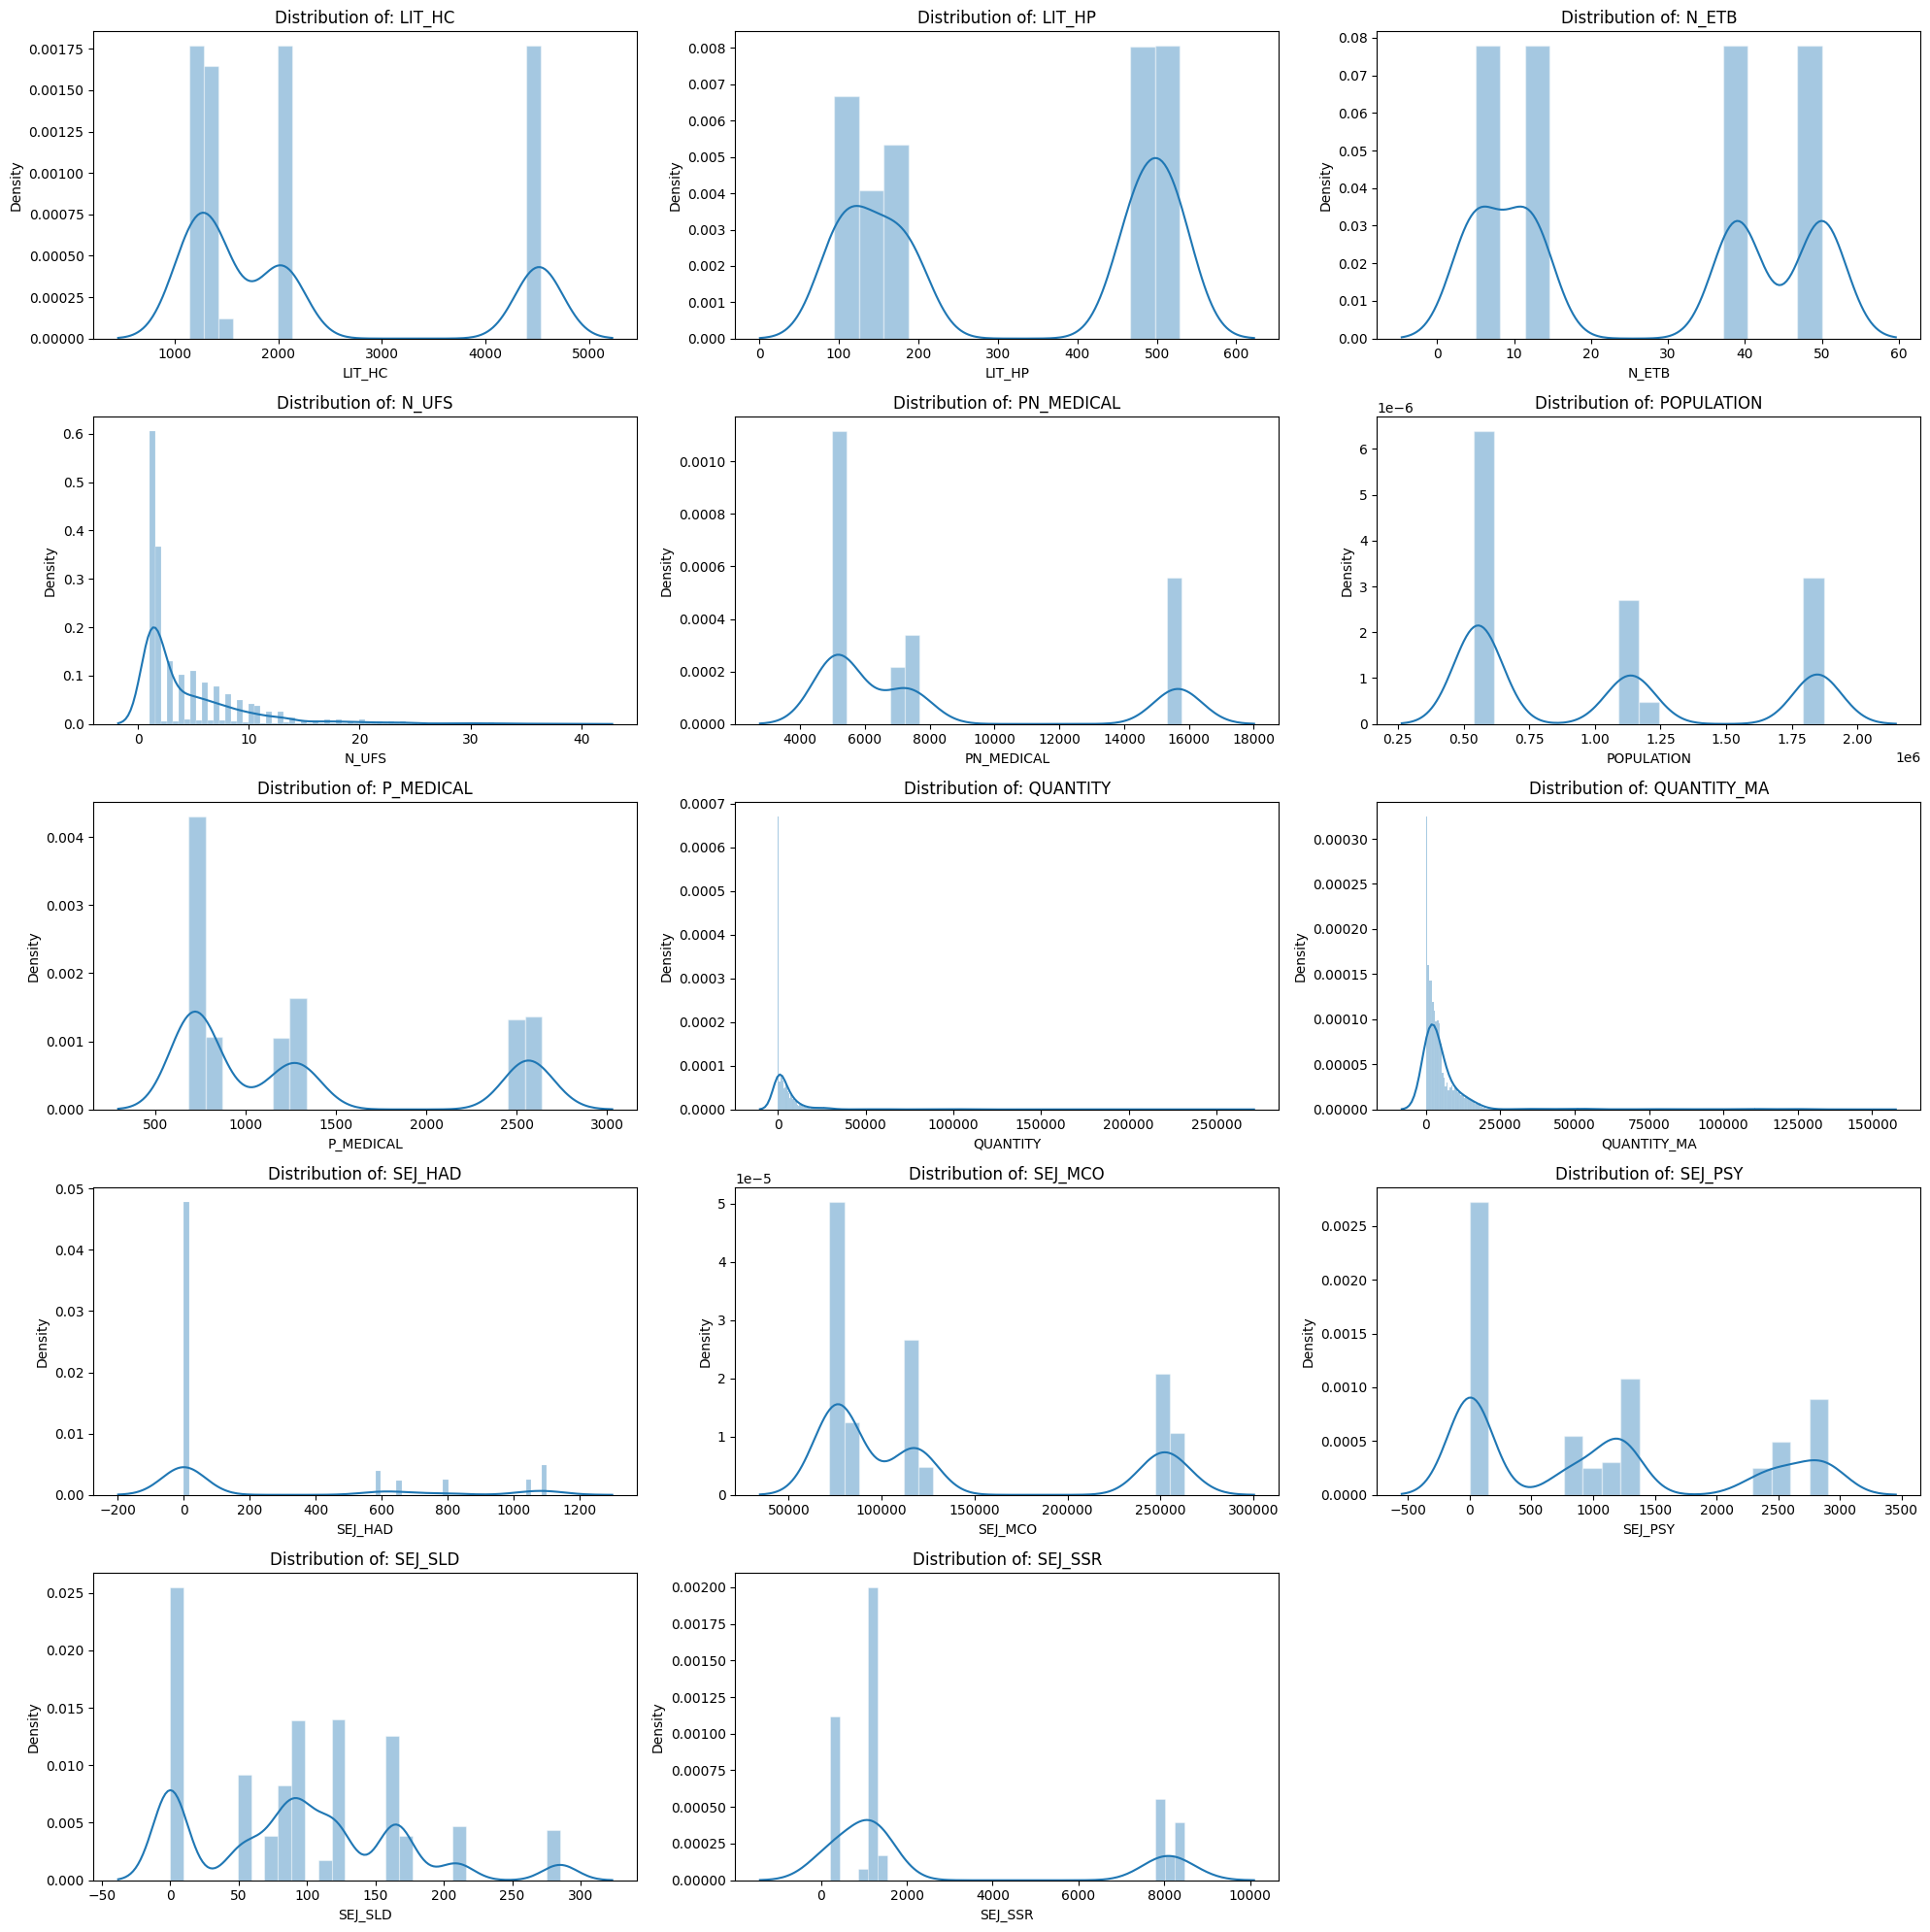

In [ ]:
visualize_distribution(df[numerical_features], data_type='numerical', n_cols=3)

## 4.1 - Train, Test split

In [12]:
X = df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy().drop(["HOSPI_CODE_UCD", 'DATE'],axis=1).values
#X_scaled = StandardScaler().fit_transform(X)

In [ ]:
X_pca = df_pca.copy().values
#X_pca_scaled = StandardScaler().fit_transform(X_pca)

## 4.2 - K-means model with different cluster composition
## &
## 4.3 - Model evaluation

In [4]:
def kmeans_clustering(X, n_clusters=2):
    model = KMeans(n_clusters=n_clusters,
                   init = 'k-means++',
                   n_init=1,
                   max_iter=10,
                   random_state=42)
    model.fit(X)
    return model

In [5]:
from sklearn.cluster import MiniBatchKMeans

def minibatch_kmeans_clustering(X, n_clusters=2):
    model = MiniBatchKMeans(n_clusters=n_clusters,
                            init='k-means++',
                            n_init=1,
                            batch_size=10,
                            max_iter=10,
                            random_state=42)
    model.fit(X)
    return model

In [6]:
def dbscan_clustering(X, eps=0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(X)
    return model


In [7]:
def agglomerative_clustering(X, n_clusters=2, metric = 'euclidean', linkage = 'ward'):

  if (linkage == 'ward') & (metric != 'euclidean'):
    print('Only euclidean metric is accepted when using ward')
    metric = 'euclidean'

  model = AgglomerativeClustering(n_clusters=n_clusters,
                                  linkage = linkage,
                                  metric = metric)

  model.fit(X)
  return model

In [8]:
def evaluate_clustering(X, n_clusters=2, verbose=False, algorithm='k-means', metric = 'euclidean', linkage = 'ward'):
    if algorithm == 'k-means':
        model = kmeans_clustering(X, n_clusters)
    elif algorithm == 'mini-batch':
        model = minibatch_kmeans_clustering(X, n_clusters)
    elif algorithm == 'dbscan':
        model = dbscan_clustering(X)
    elif algorithm == 'agglomerative':
        model = agglomerative_clustering(X, n_clusters, metric, linkage)

    labels = model.fit_predict(X)

    silhouette = metrics.silhouette_score(X, labels, metric=metric)
    davies_bouldin = metrics.davies_bouldin_score(X, labels)

    if verbose:

        print(f'--- Algorithm: {algorithm}')
        metrics_string = '#'*10+' Metrics for test split - '+f'{n_clusters} clusters '+'#'*10
        print()
        print('#'*len(metrics_string))
        print(metrics_string)
        print()
        print(f'Silhouette Score: {round(silhouette, 2)}')
        print(f'Davies-Bouldin Score: {round(davies_bouldin, 2)}')
        print()
        print('#'*len(metrics_string))
        print('#'*len(metrics_string))
        print()

    return silhouette, davies_bouldin

In [9]:
def visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm):

  # Find optimal cluster numbers based on the scores
  s_max = np.argmax(s_scores)+2
  dbs_min = np.argmin(dbs_scores)+2

  # Print the best scores and cluster numbers
  string_array = '#'*10 + ' Metrics best performance for different clusters - Algorithm: ' + f'{algorithm}' + '#'*10
  len_string_array = len(string_array)
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()
  print(string_array)
  print(f'Best score for Silhouette metric: {max(s_scores):.2f} for {s_max} clusters')
  print(f'Best score for Davies Bouldin metric: {min(dbs_scores):.2f} for {dbs_min} clusters')
  print()
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()

  # Plot Silhouette scores
  x = np.arange(min_clusters, max_clusters+1)
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

  # Plot Silhouette scores
  axs[0].stem(x, s_scores, linefmt='C0-', markerfmt='C0o', basefmt=' ')
  axs[0].set_xlabel('Number of Clusters')
  axs[0].set_ylabel('Silhouette Score')
  axs[0].set_title('Silhouette Scores for Different Cluster Numbers')
  axs[0].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[0].set_ylim([0, 1])
  axs[0].grid(True)

  # Plot Davies Bouldin Scores
  axs[1].stem(x, dbs_scores, linefmt='C1-', markerfmt='C1o', basefmt=' ')
  axs[1].set_xlabel('Number of Clusters')
  axs[1].set_ylabel('Davies Bouldin Score')
  axs[1].set_title('Davies Bouldin Scores for Different Cluster Numbers')
  axs[1].set_xticks(np.arange(2, max_clusters+1, 1))
  axs[1].set_ylim([0, 1])
  axs[1].grid(True)

  plt.show()

In [10]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import time

def create_elbow_plot(X, max_clusters=10, sample_fraction=0.1):
    # Sample a subset of the data for faster processing (optional)
    n_samples = int(sample_fraction * len(X))
    X_sample = X[:n_samples]

    # Initialize lists to store inertia and training times
    kmeans_inertia = []
    kmeans_train_time = []
    minibatch_inertia = []
    minibatch_train_time = []

    # Perform K-means clustering for different numbers of clusters
    for n_clusters in range(1, max_clusters + 1):
        # Perform K-means clustering
        start_time = time.time()
        kmeans = KMeans(n_clusters=n_clusters,
                        init = 'k-means++',
                        n_init=1,
                        max_iter=10,
                        random_state=42)

        kmeans.fit(X_sample)
        train_time = time.time() - start_time

        # Calculate inertia (within-cluster sum of squares)
        inertia = kmeans.inertia_

        # Append inertia and training time to the respective lists
        kmeans_inertia.append(inertia)
        kmeans_train_time.append(train_time)

    # Perform Mini-Batch K-means clustering for different numbers of clusters
    for n_clusters in range(1, max_clusters + 1):
        # Perform Mini-Batch K-means clustering
        start_time = time.time()
        minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                                           init = 'k-means++',
                                           n_init=1,
                                           max_iter=10,
                                           batch_size=10,
                                           random_state=42)
        minibatch_kmeans.fit(X_sample)
        train_time = time.time() - start_time

        # Calculate inertia (within-cluster sum of squares)
        distances = pairwise_distances_argmin_min(X_sample, minibatch_kmeans.cluster_centers_)
        minibatch_inertia.append(sum(distances[1]))

        # Append inertia and training time to the respective lists
        minibatch_train_time.append(train_time)

    # Create the plots
    plt.figure(figsize=(12, 5))

    # Elbow plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), kmeans_inertia, marker='o', label='K-means')
    plt.plot(range(1, max_clusters + 1), minibatch_inertia, marker='o', label='Mini-Batch K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot for K-means and Mini-Batch K-means')
    plt.grid(True)
    plt.legend()

    # Training time plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_clusters + 1), kmeans_train_time, marker='o', label='K-means')
    plt.plot(range(1, max_clusters + 1), minibatch_train_time, marker='o', label='Mini-Batch K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time for K-means and Mini-Batch K-means')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


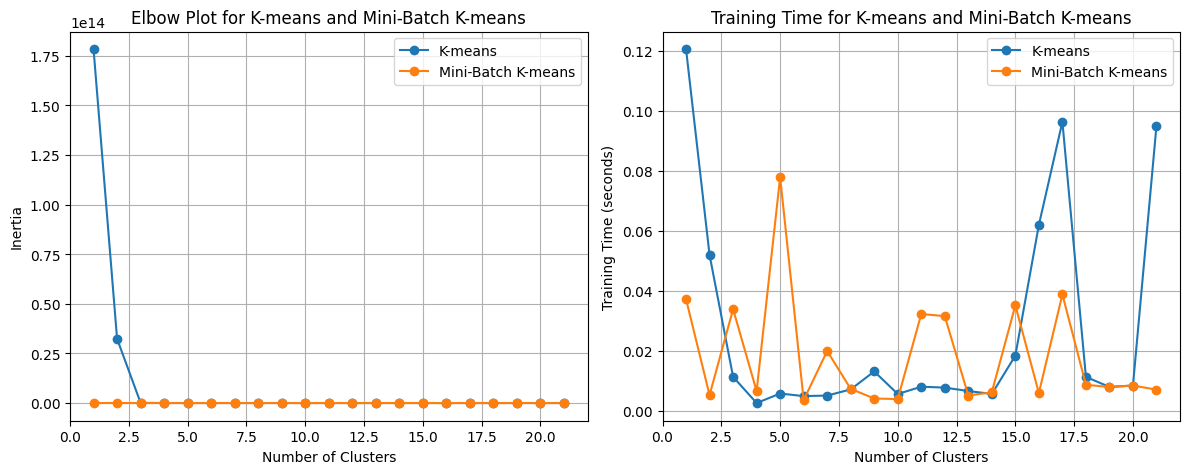

In [13]:
create_elbow_plot(X, max_clusters=21, sample_fraction=0.1)

In [14]:
create_elbow_plot(X_pca, max_clusters=15, sample_fraction=0.1)

NameError: ignored

-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: k-means##########
Best score for Silhouette metric: 0.96 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------



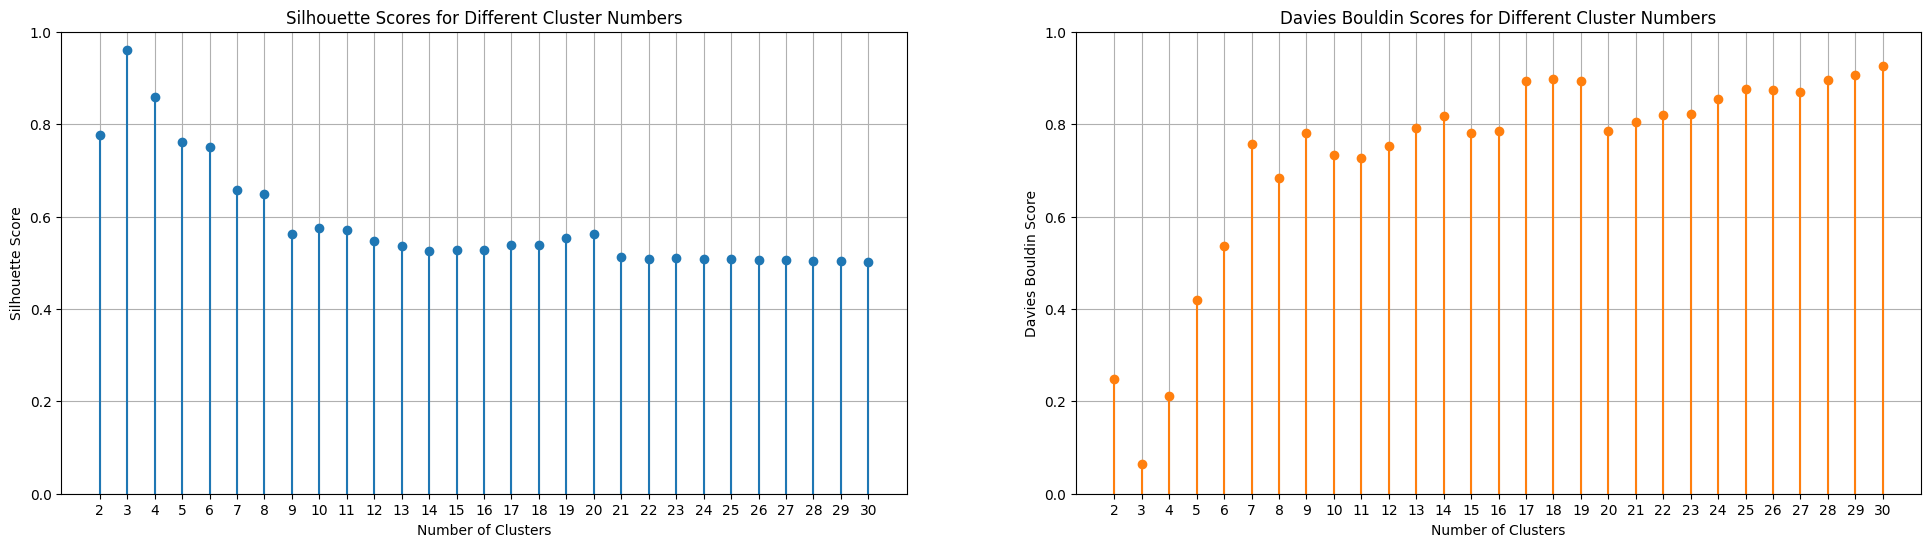

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: mini-batch##########
Best score for Silhouette metric: 0.96 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------



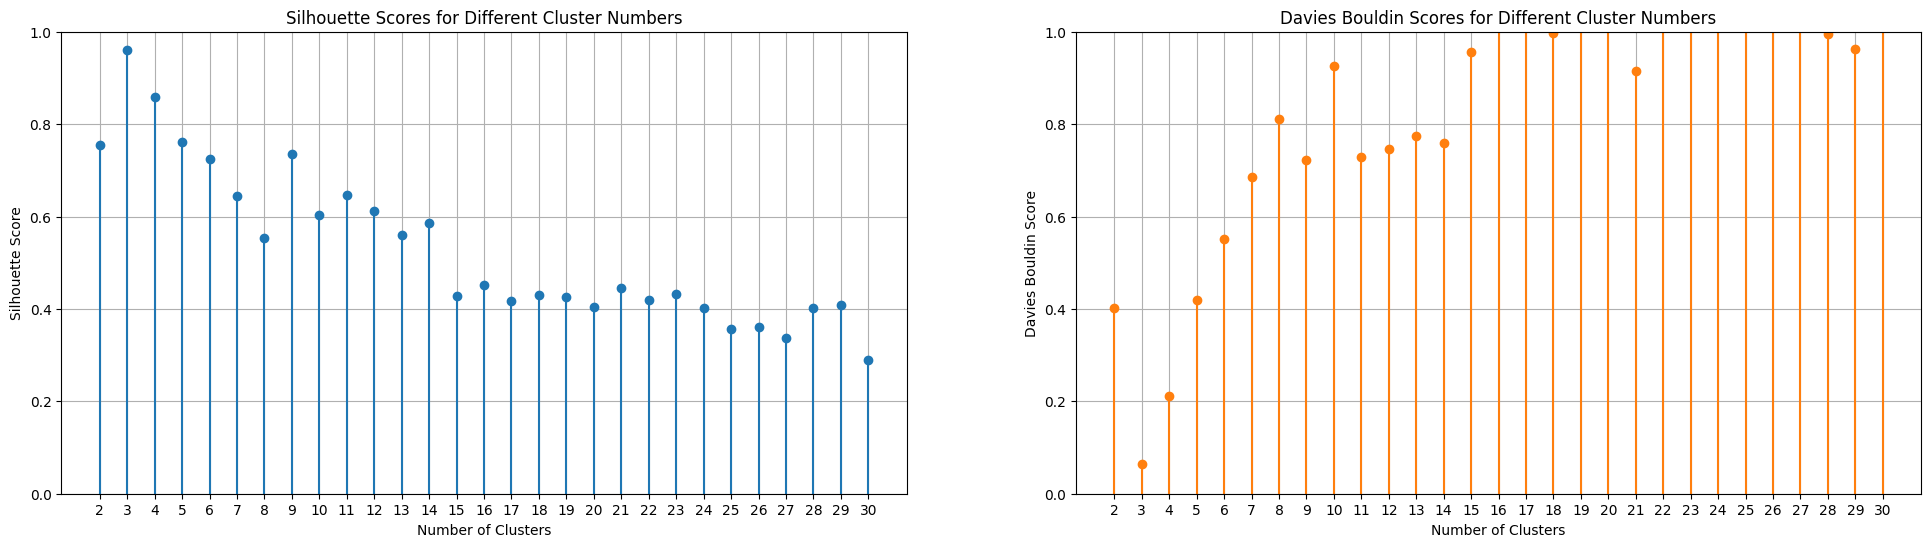

--- Metric: l1
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.94 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



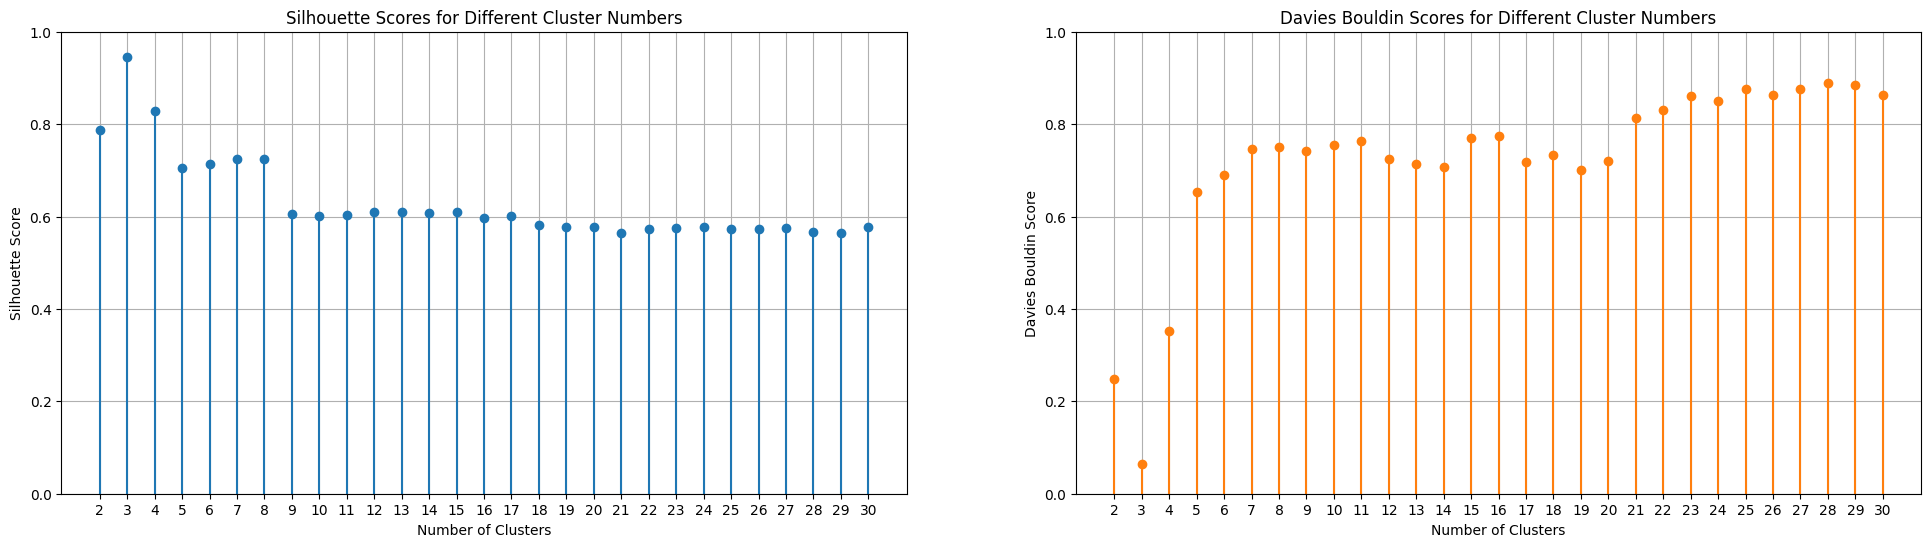

--- Metric: l2
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.96 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



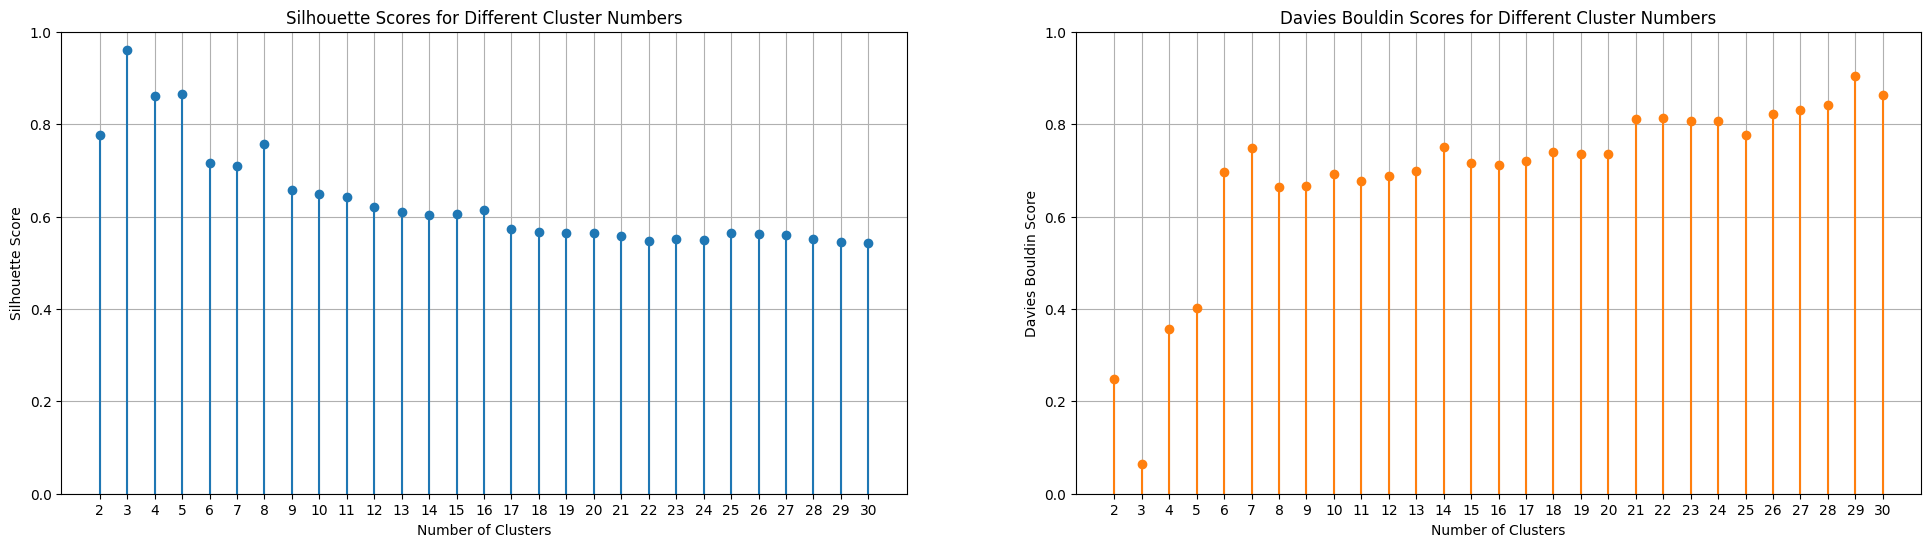

--- Metric: manhattan
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.94 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



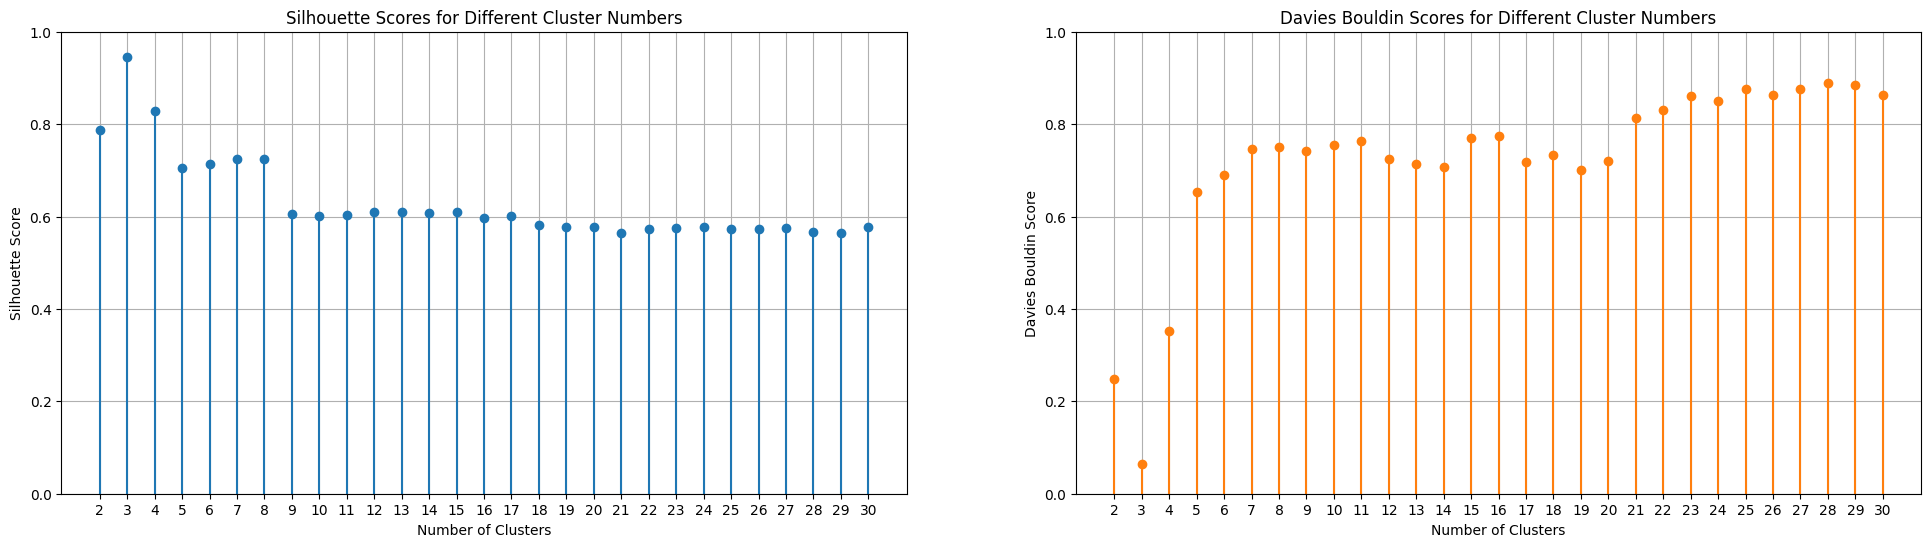

--- Metric: cosine
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.82 for 3 clusters
Best score for Davies Bouldin metric: 0.99 for 2 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



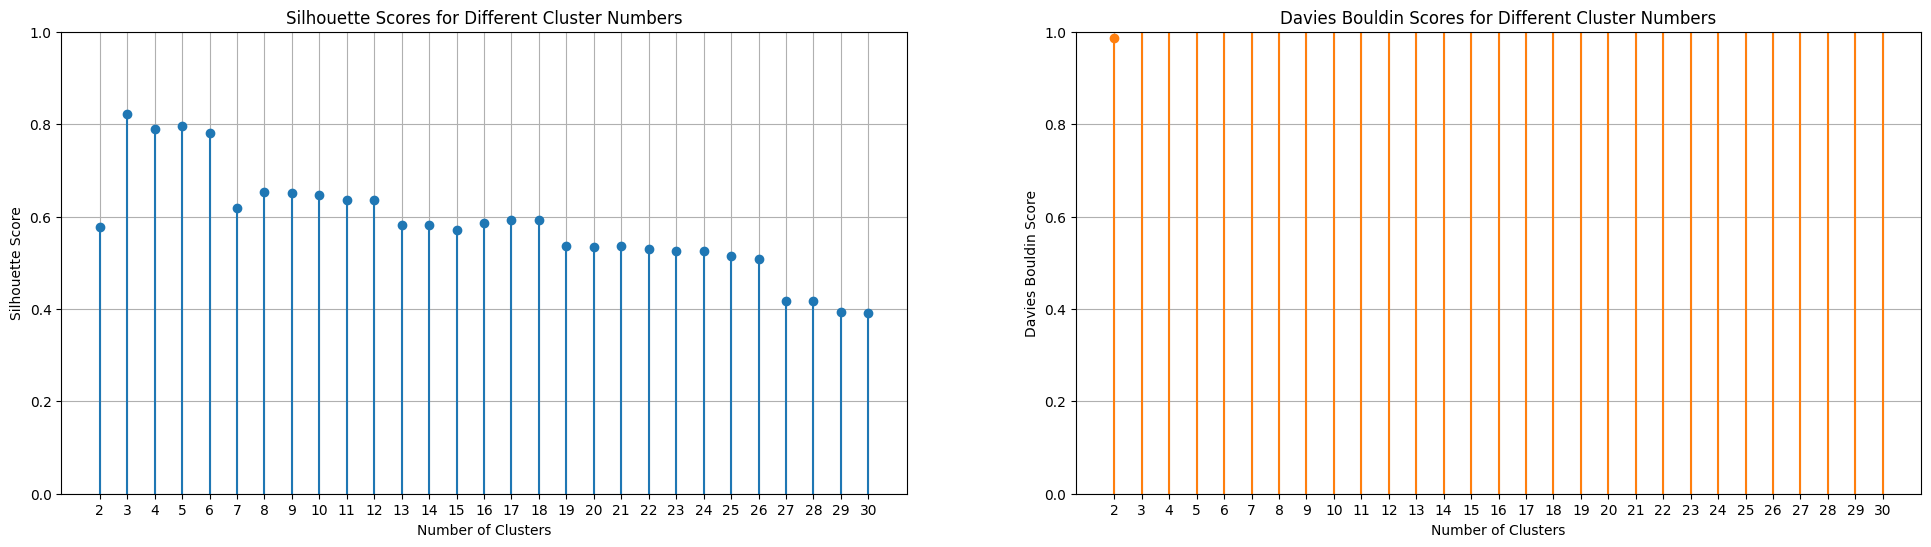

--- Metric: l1
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.94 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



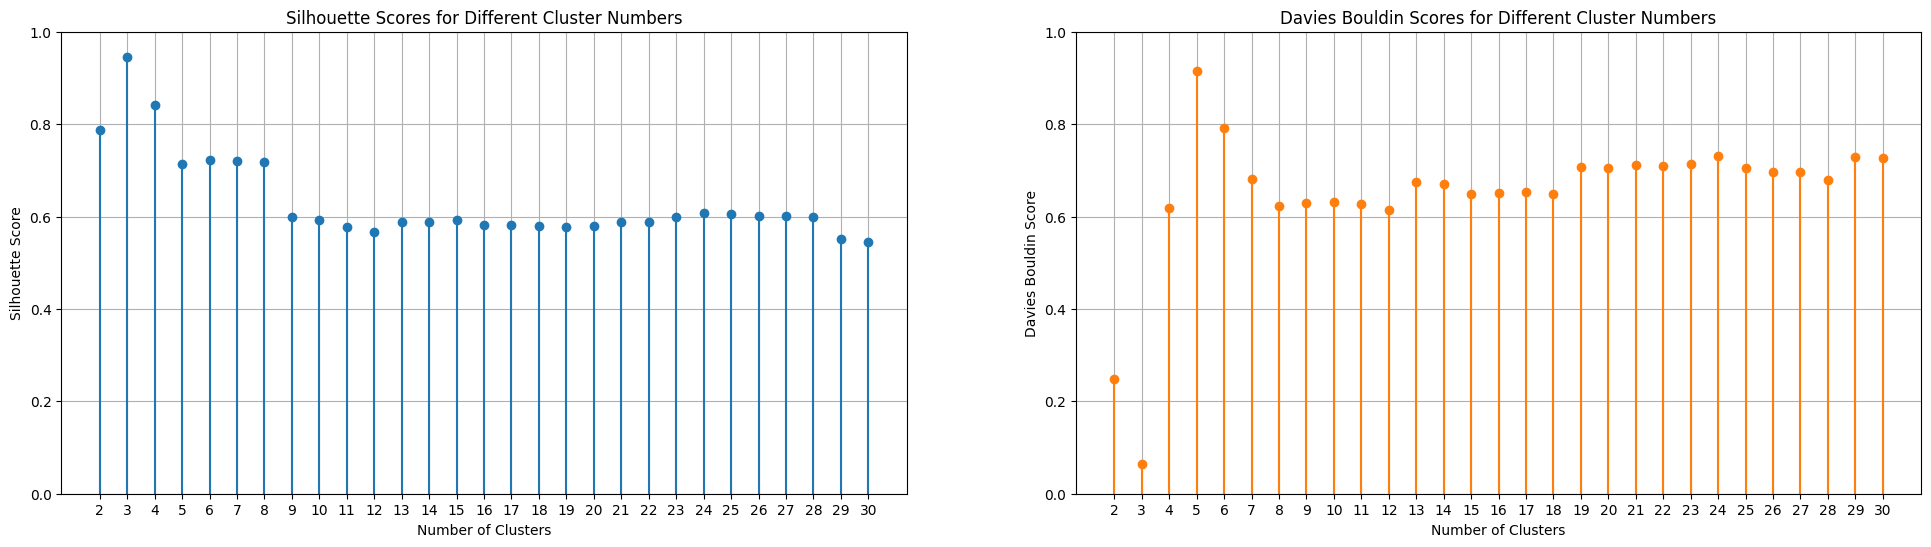

--- Metric: l2
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.96 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



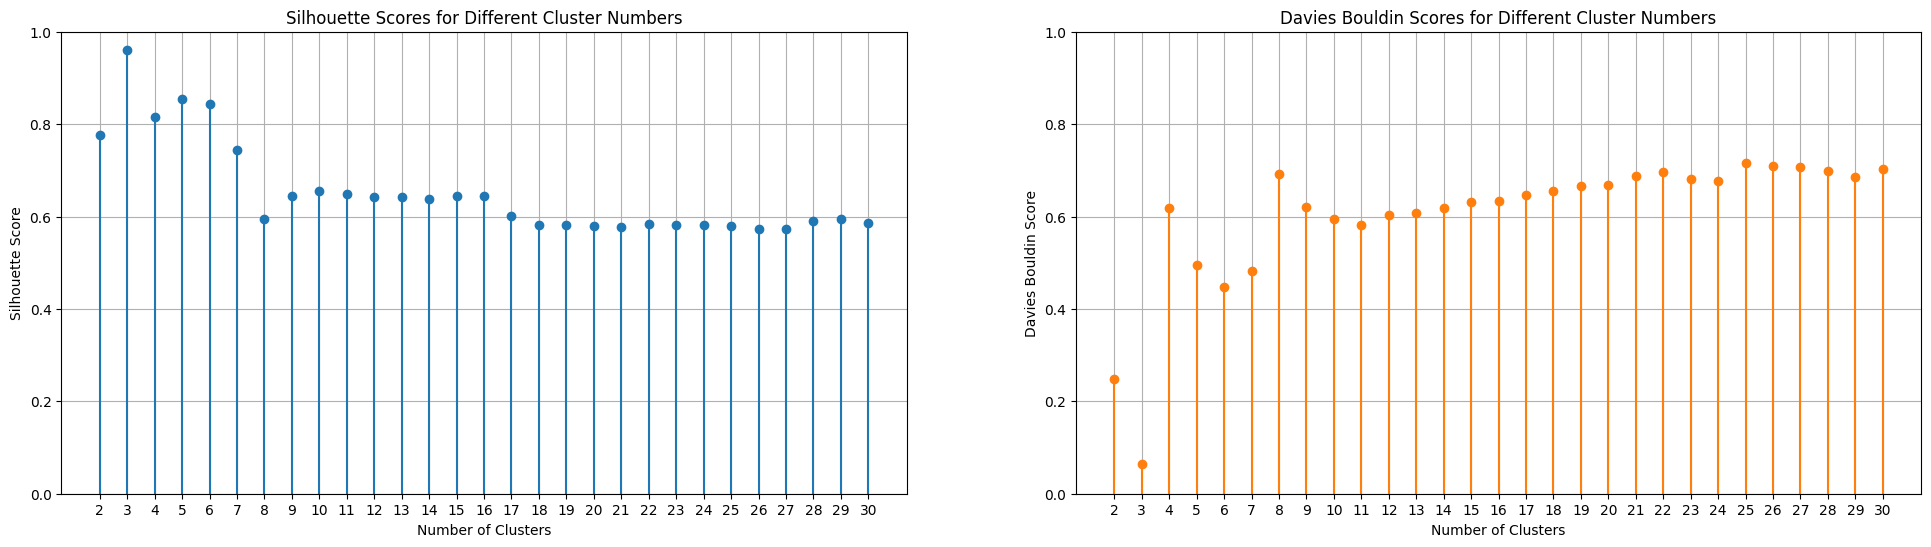

--- Metric: manhattan
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.94 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



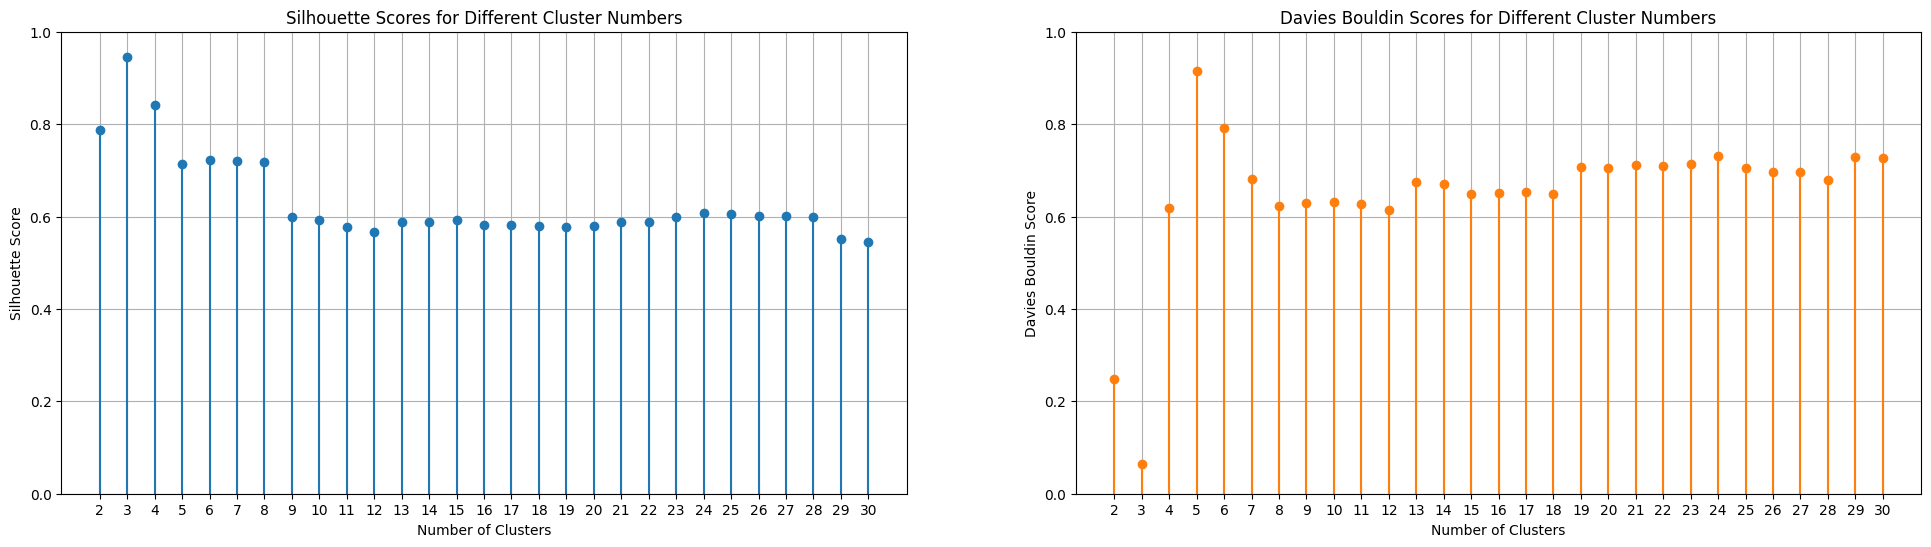

--- Metric: cosine
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.83 for 4 clusters
Best score for Davies Bouldin metric: 2.54 for 16 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



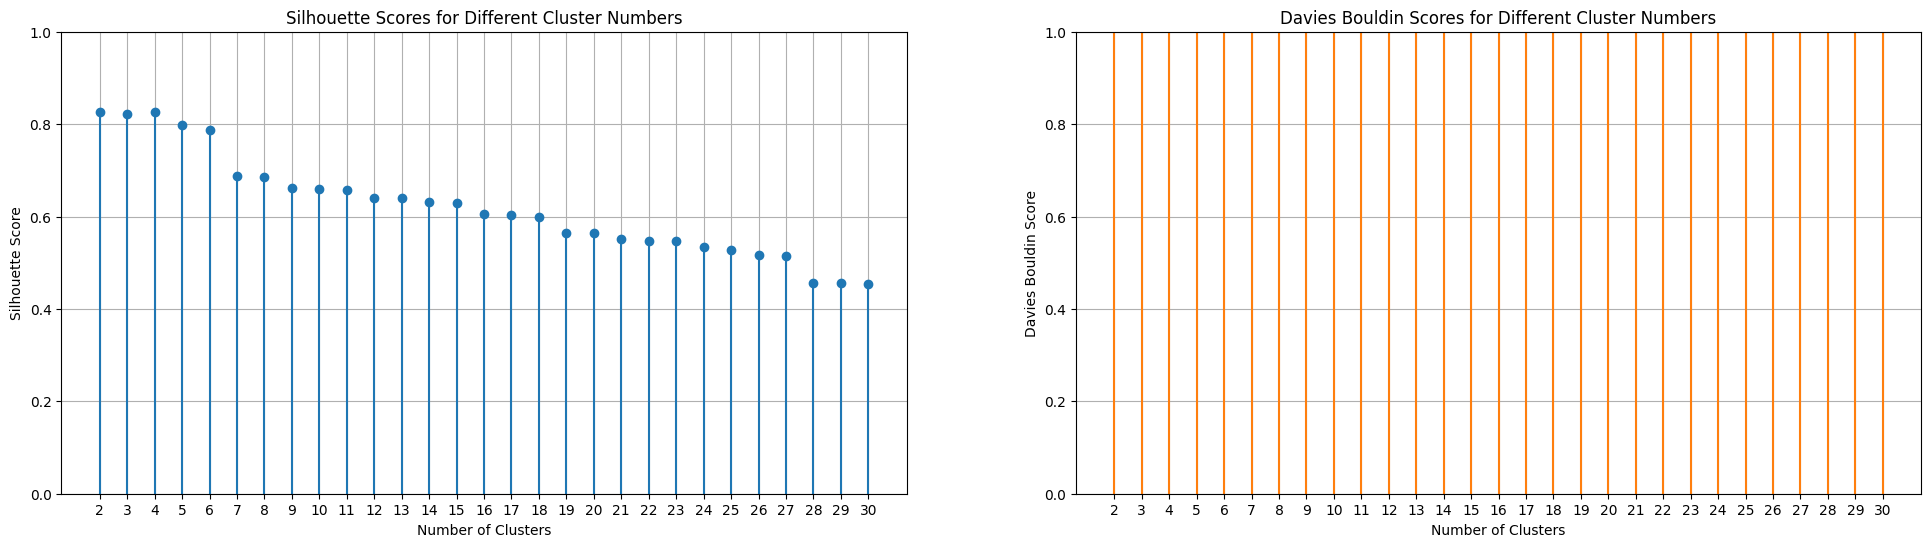

--- Metric: l1
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.94 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



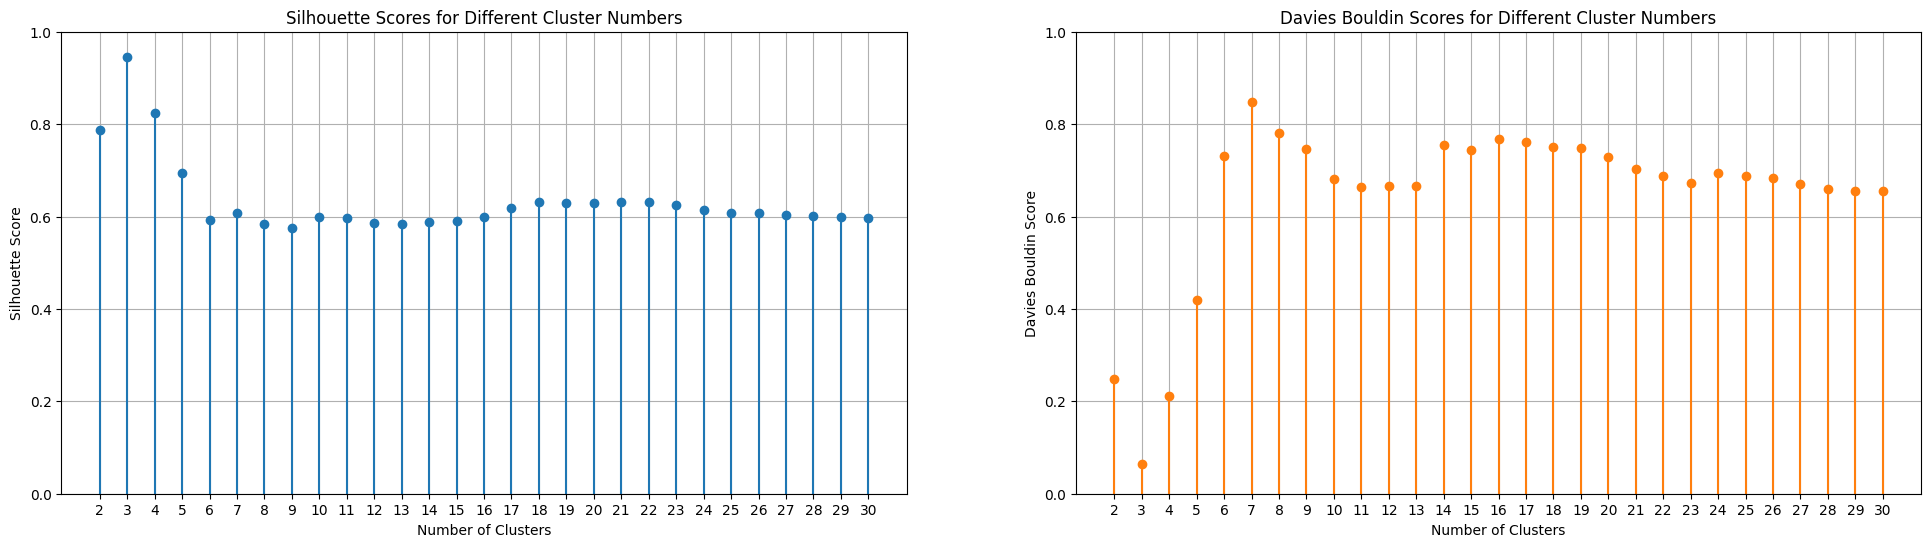

--- Metric: l2
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.96 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



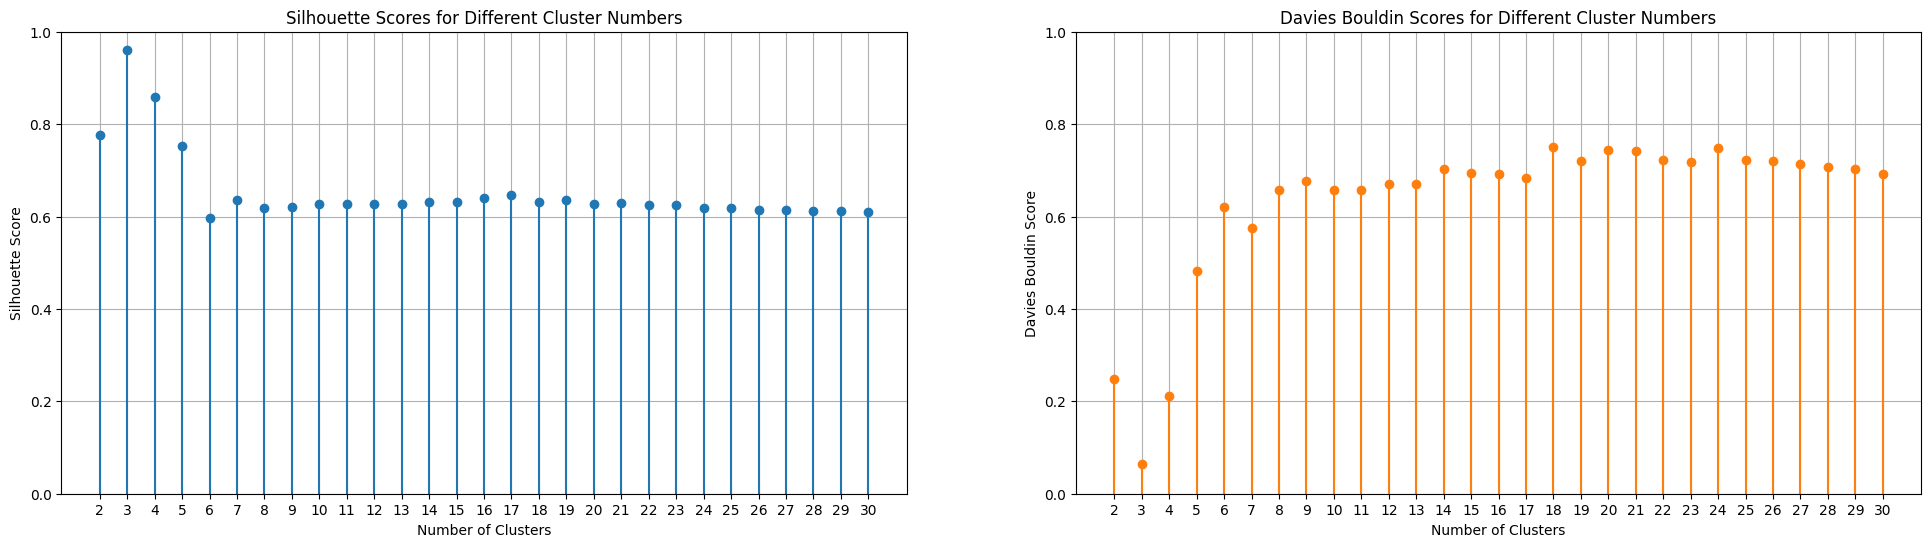

--- Metric: manhattan
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.94 for 3 clusters
Best score for Davies Bouldin metric: 0.06 for 3 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



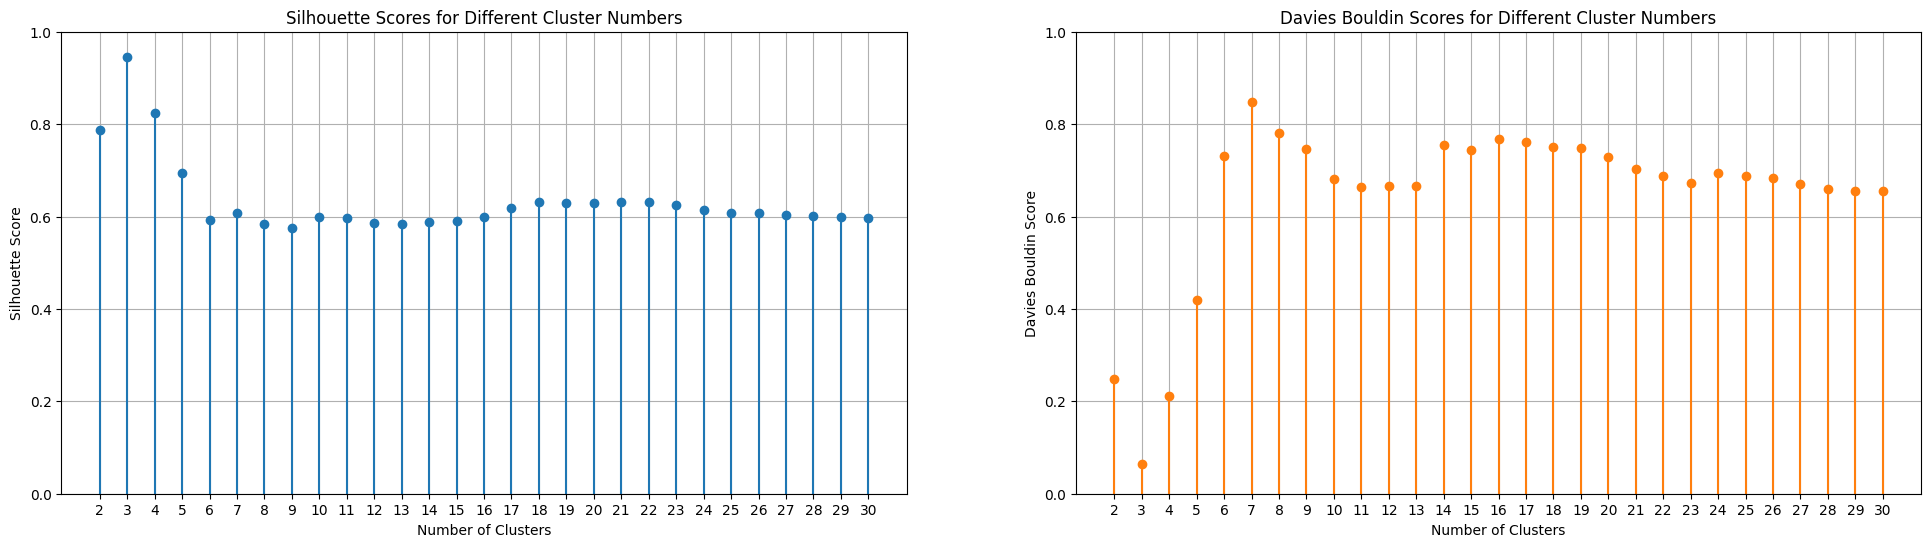

--- Metric: cosine
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.83 for 2 clusters
Best score for Davies Bouldin metric: 1.94 for 17 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



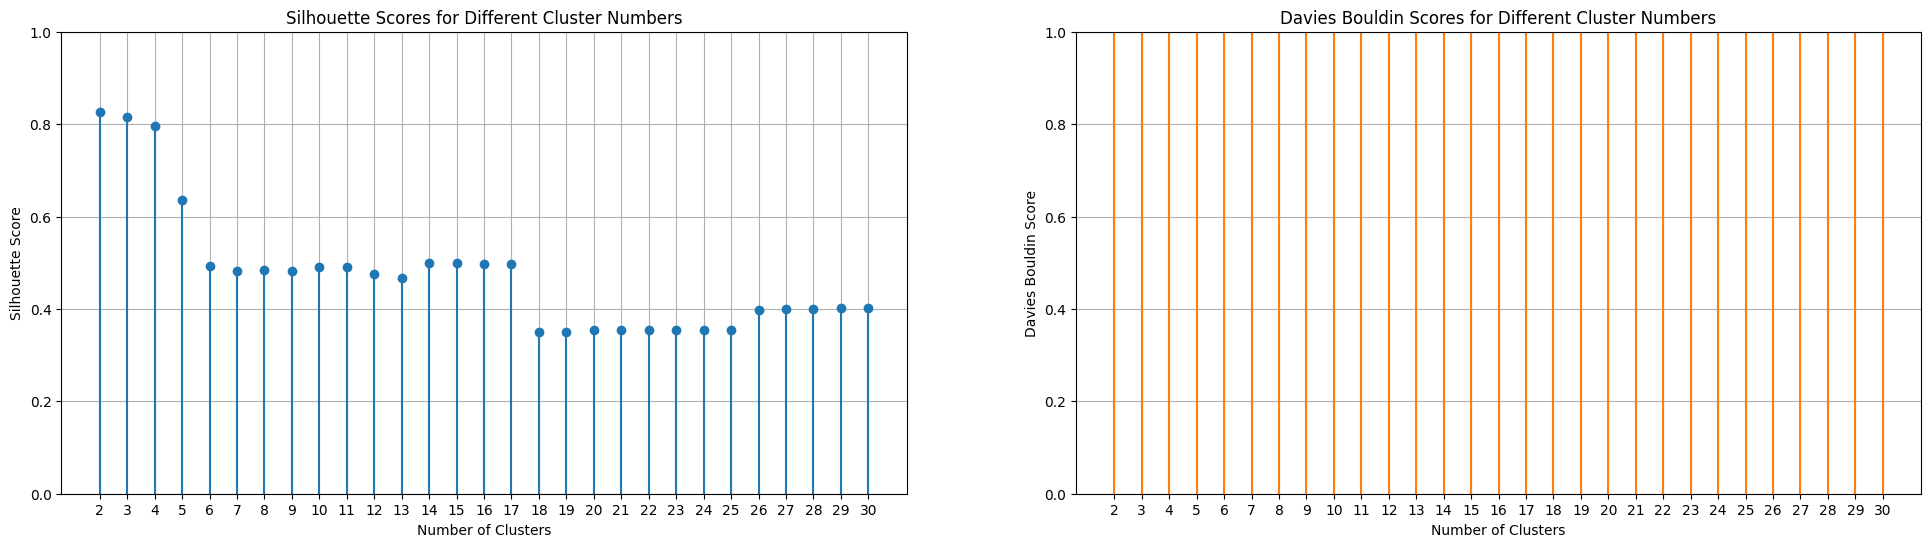

--- Metric: Euclidean
--- Linkage: Ward
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.83 for 2 clusters
Best score for Davies Bouldin metric: 0.81 for 30 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



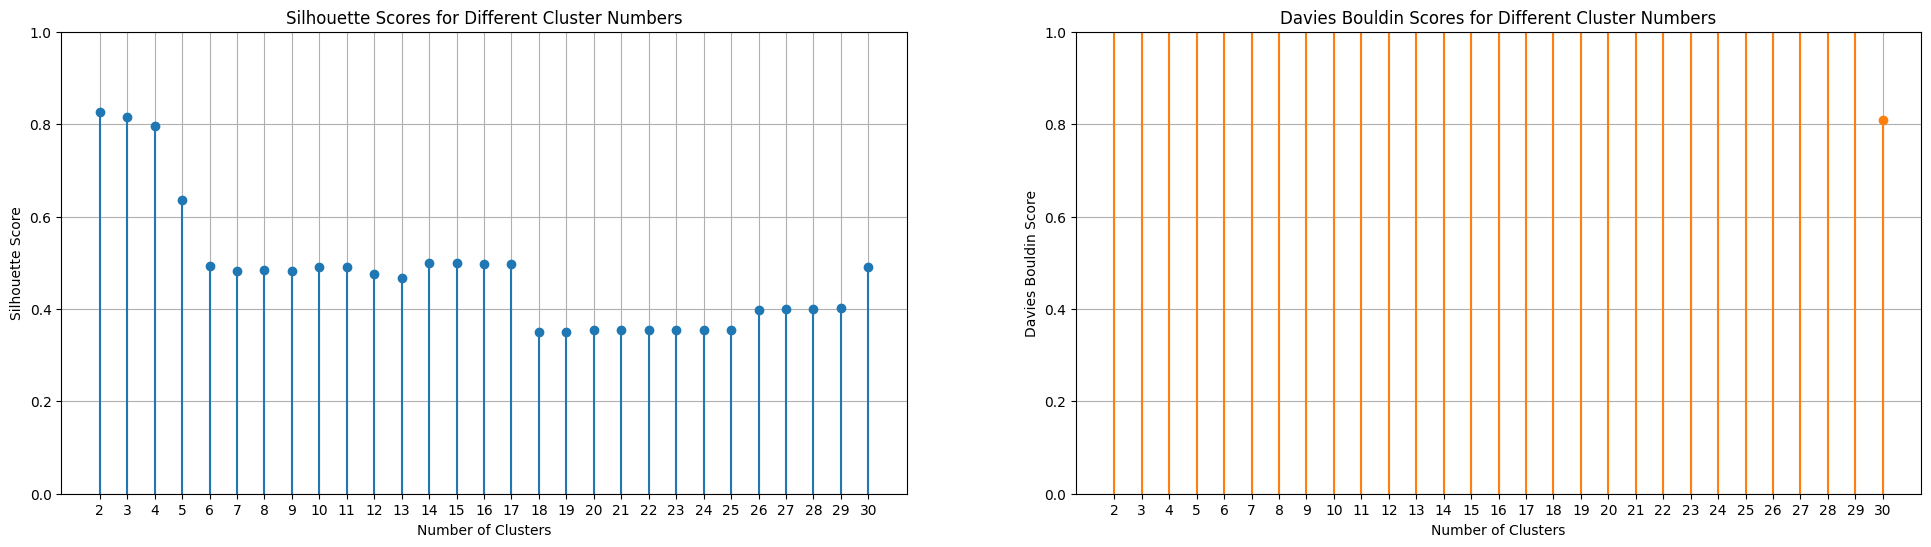

Not possible to run: dbscan


In [16]:
min_clusters = 2
max_clusters = 30

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for algorithm in ['k-means', 'mini-batch', 'agglomerative', 'dbscan']:
  try:
    if algorithm == 'agglomerative':
      for linkage in ['complete', 'average', 'single']:
        for metric in ['l1', 'l2', 'manhattan','cosine']:
          for n_clusters in clusters:
            s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_clustering(X, n_clusters, algorithm = algorithm, metric = metric, linkage = linkage)
          print(f'--- Metric: {metric}')
          print(f'--- Linkage: {linkage}')
          visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm)
      print('--- Metric: Euclidean')
      print('--- Linkage: Ward')
      s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_clustering(X, n_clusters, algorithm = algorithm, metric = 'euclidean', linkage = 'ward')
      visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm)

    else:
      for n_clusters in clusters:
        s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_clustering(X, n_clusters, algorithm = algorithm)
      visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm)
  except:
    print(f'Not possible to run: {algorithm}')

-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: k-means##########
Best score for Silhouette metric: 0.26 for 2 clusters
Best score for Davies Bouldin metric: 1.51 for 2 clusters

-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------



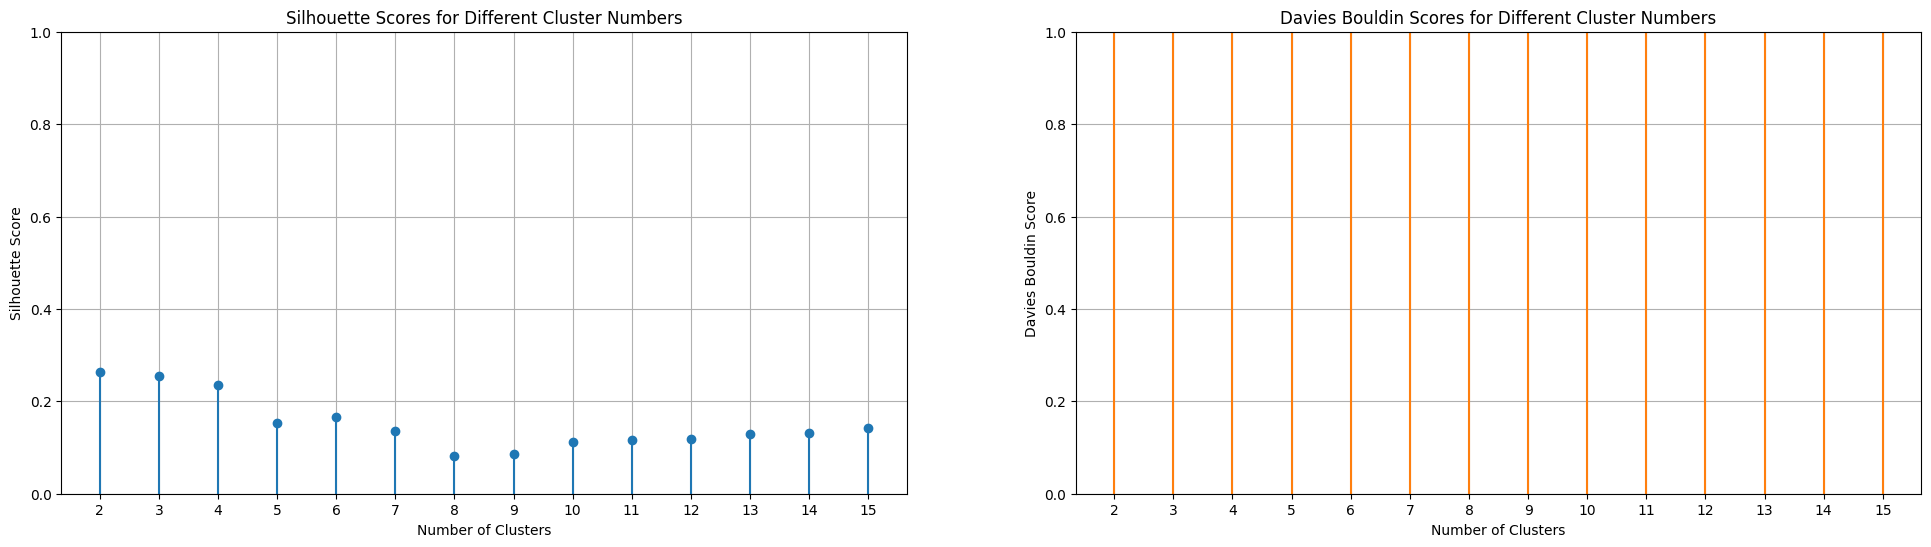

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: mini-batch##########
Best score for Silhouette metric: 0.26 for 2 clusters
Best score for Davies Bouldin metric: 1.51 for 2 clusters

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------



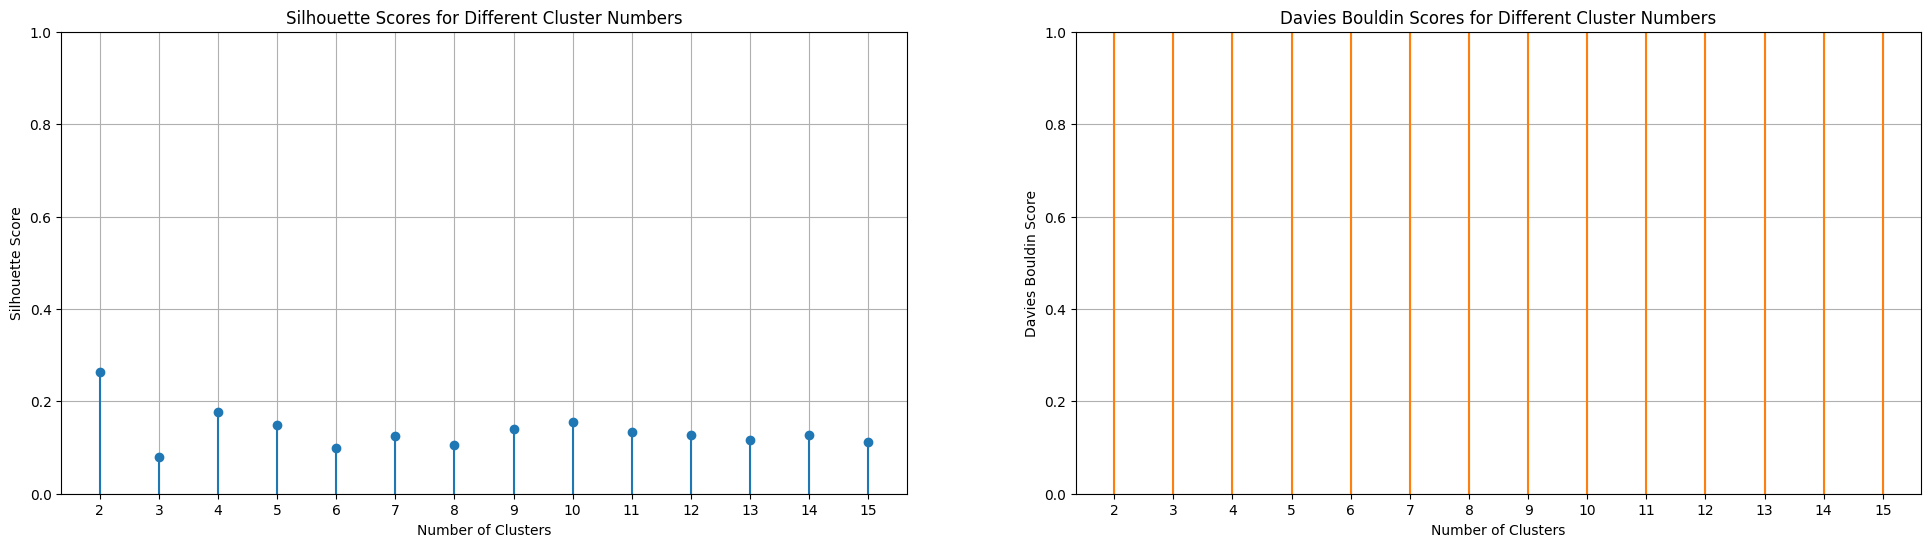

--- Metric: l1
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.17 for 15 clusters
Best score for Davies Bouldin metric: 2.26 for 15 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



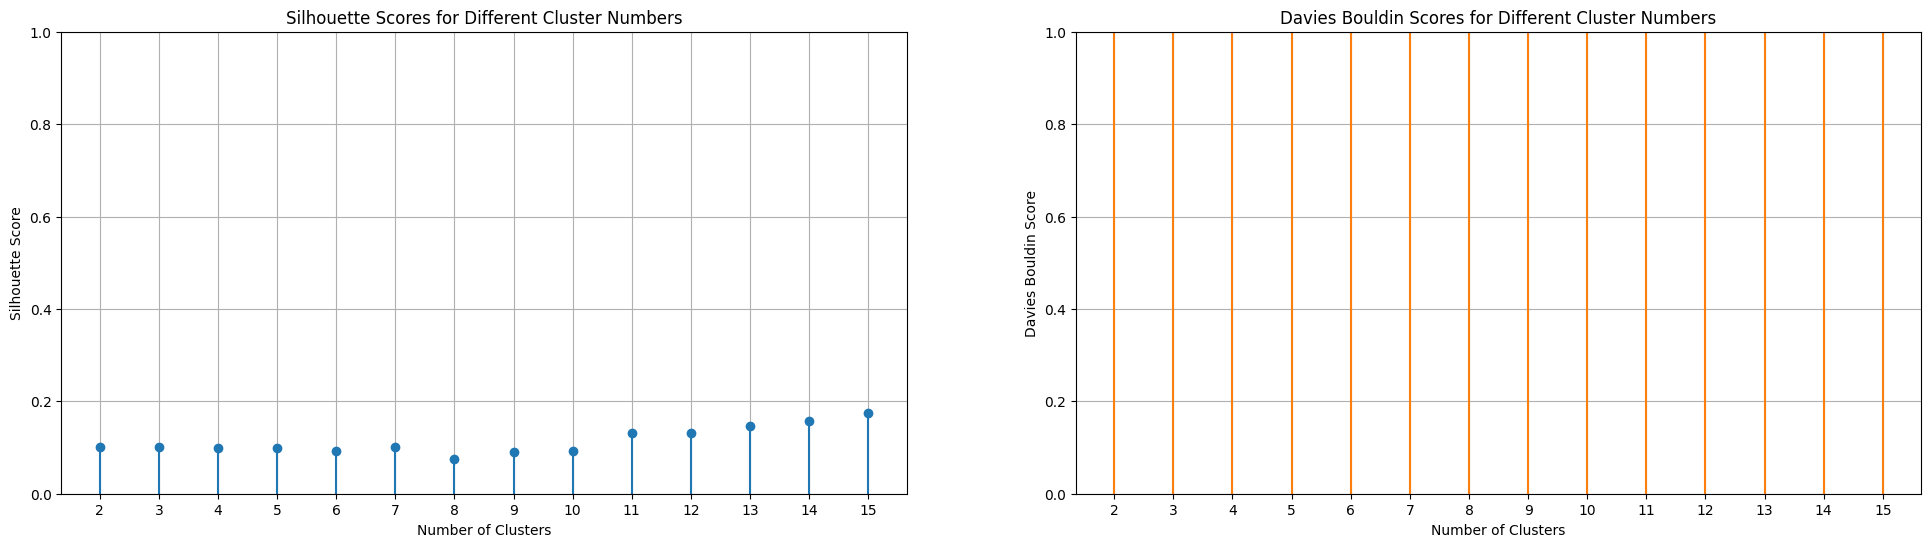

--- Metric: l2
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.19 for 2 clusters
Best score for Davies Bouldin metric: 1.78 for 4 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



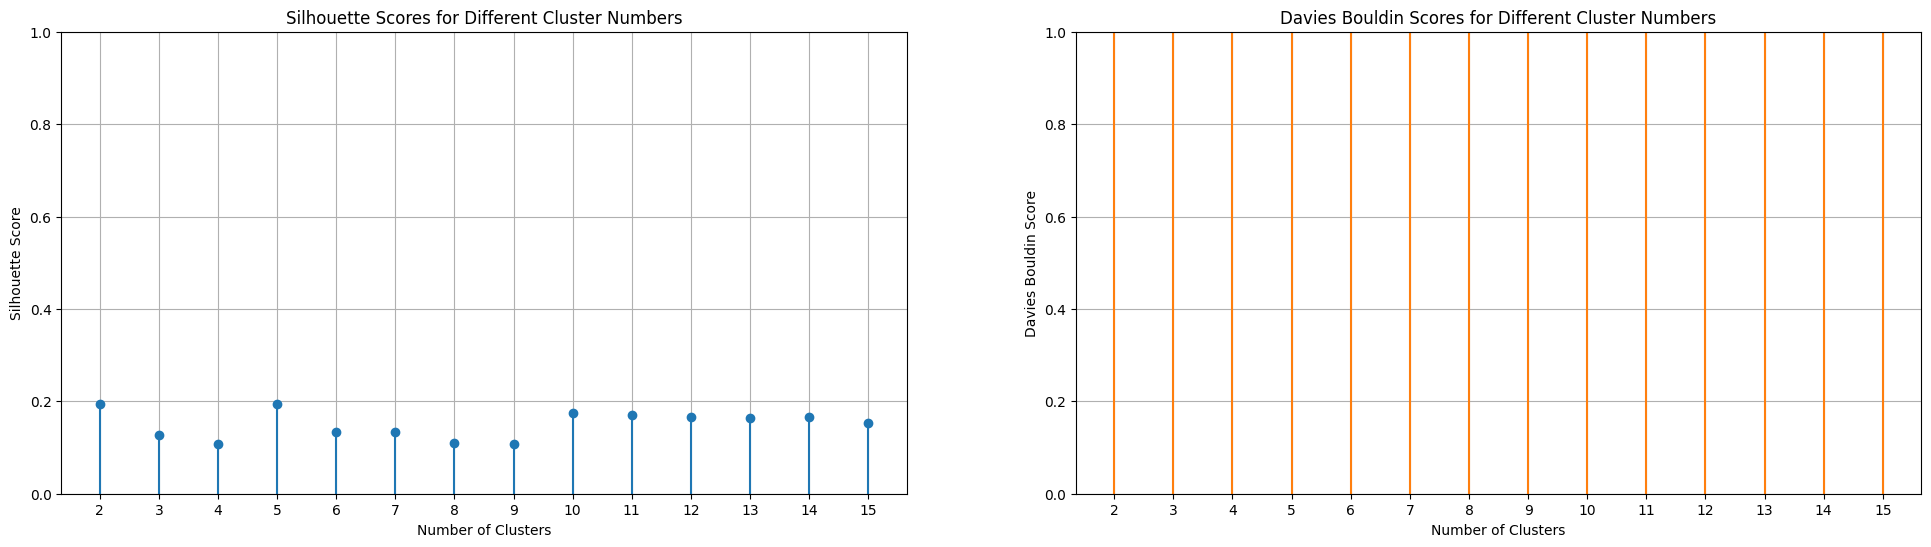

--- Metric: manhattan
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.17 for 15 clusters
Best score for Davies Bouldin metric: 2.26 for 15 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



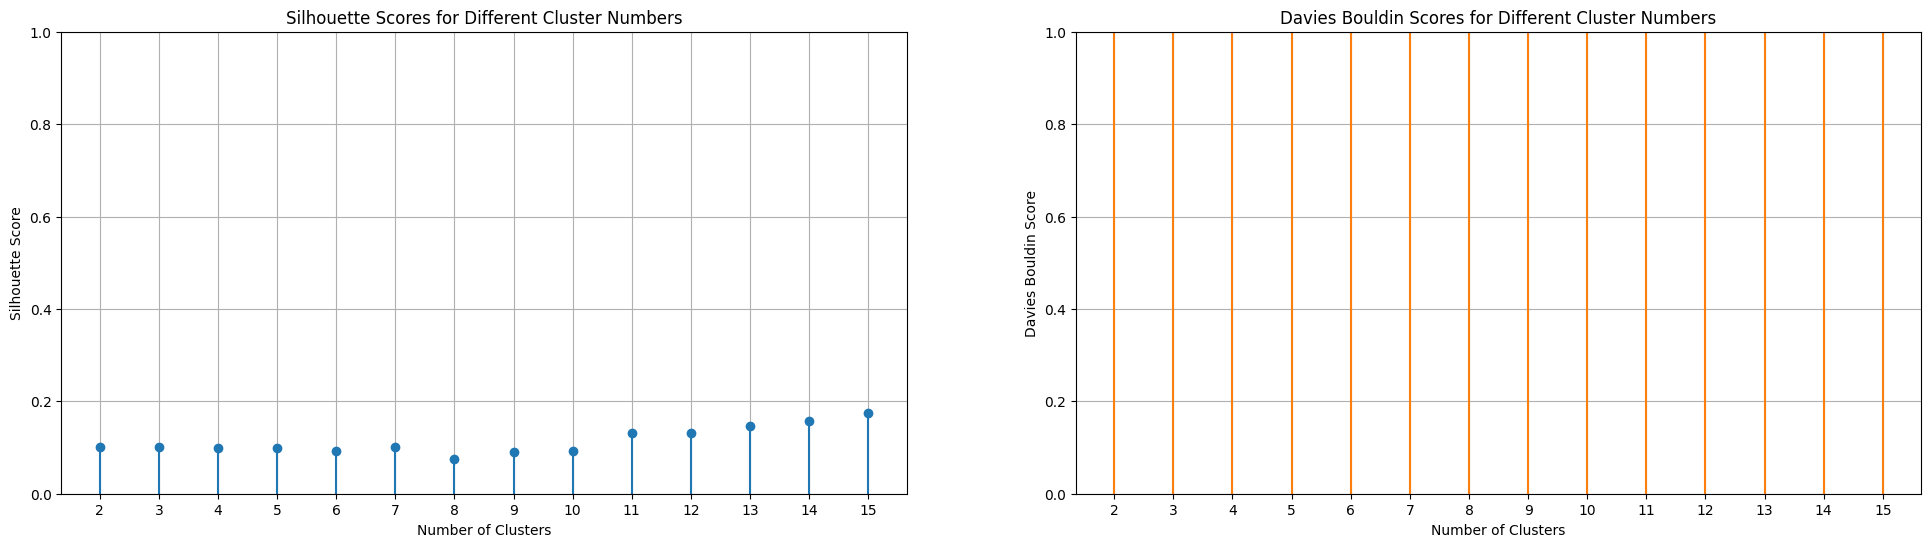

--- Metric: cosine
--- Linkage: complete
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.35 for 4 clusters
Best score for Davies Bouldin metric: 1.51 for 2 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



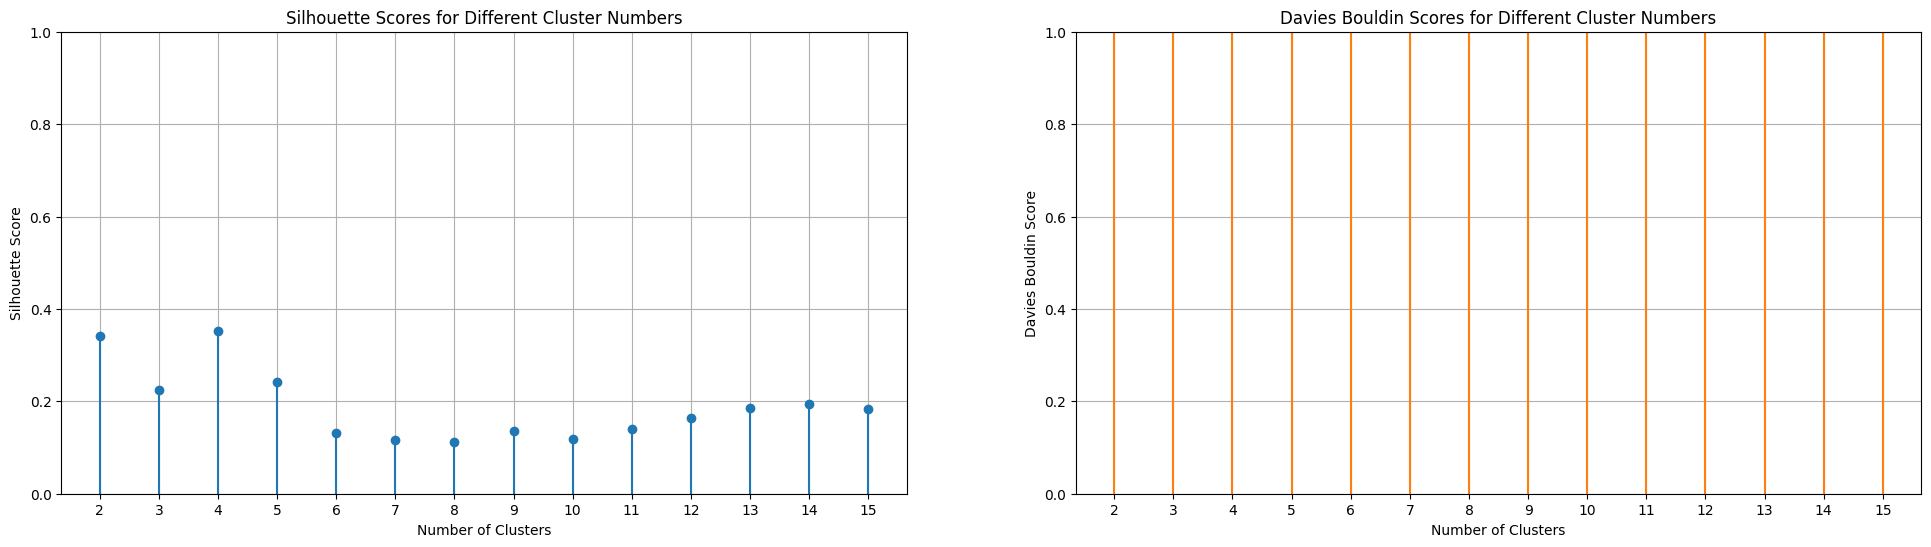

--- Metric: l1
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.29 for 2 clusters
Best score for Davies Bouldin metric: 1.08 for 2 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



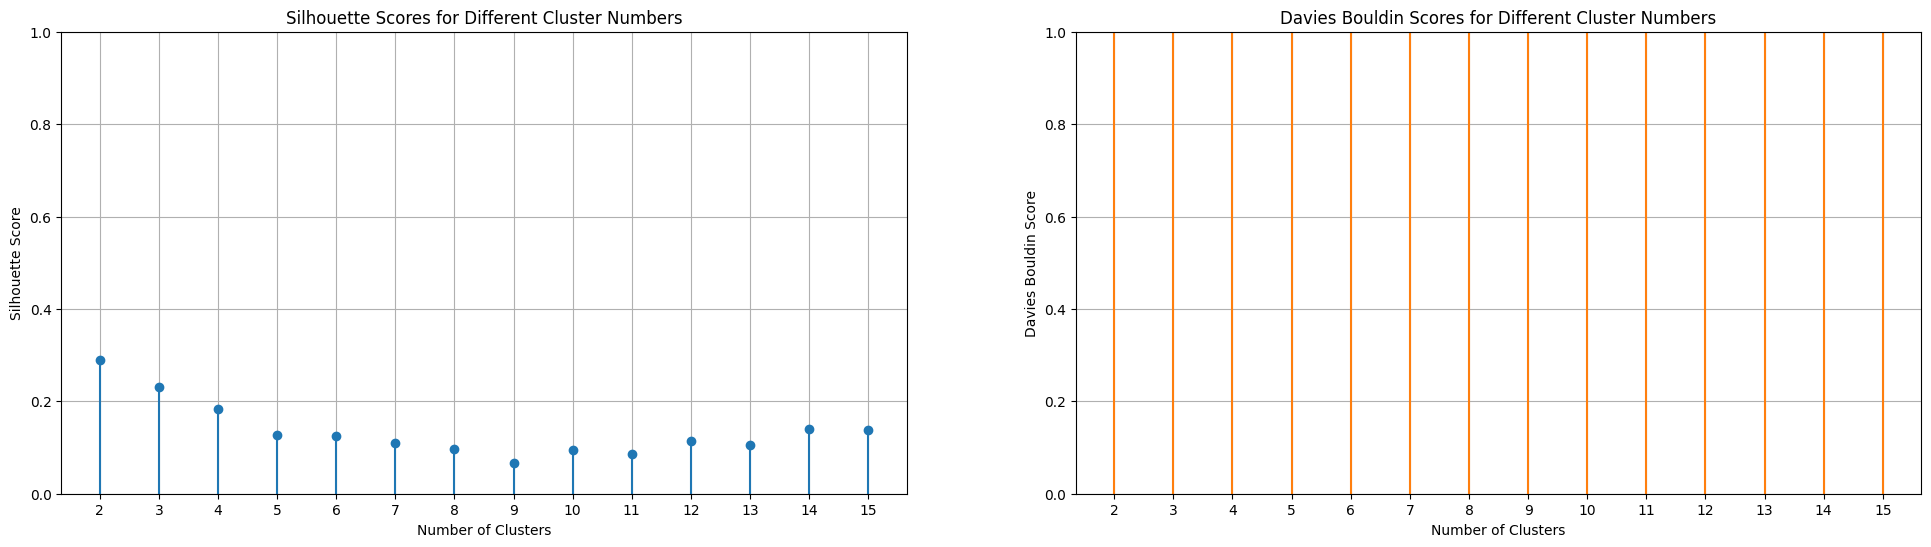

--- Metric: l2
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.25 for 4 clusters
Best score for Davies Bouldin metric: 1.25 for 6 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



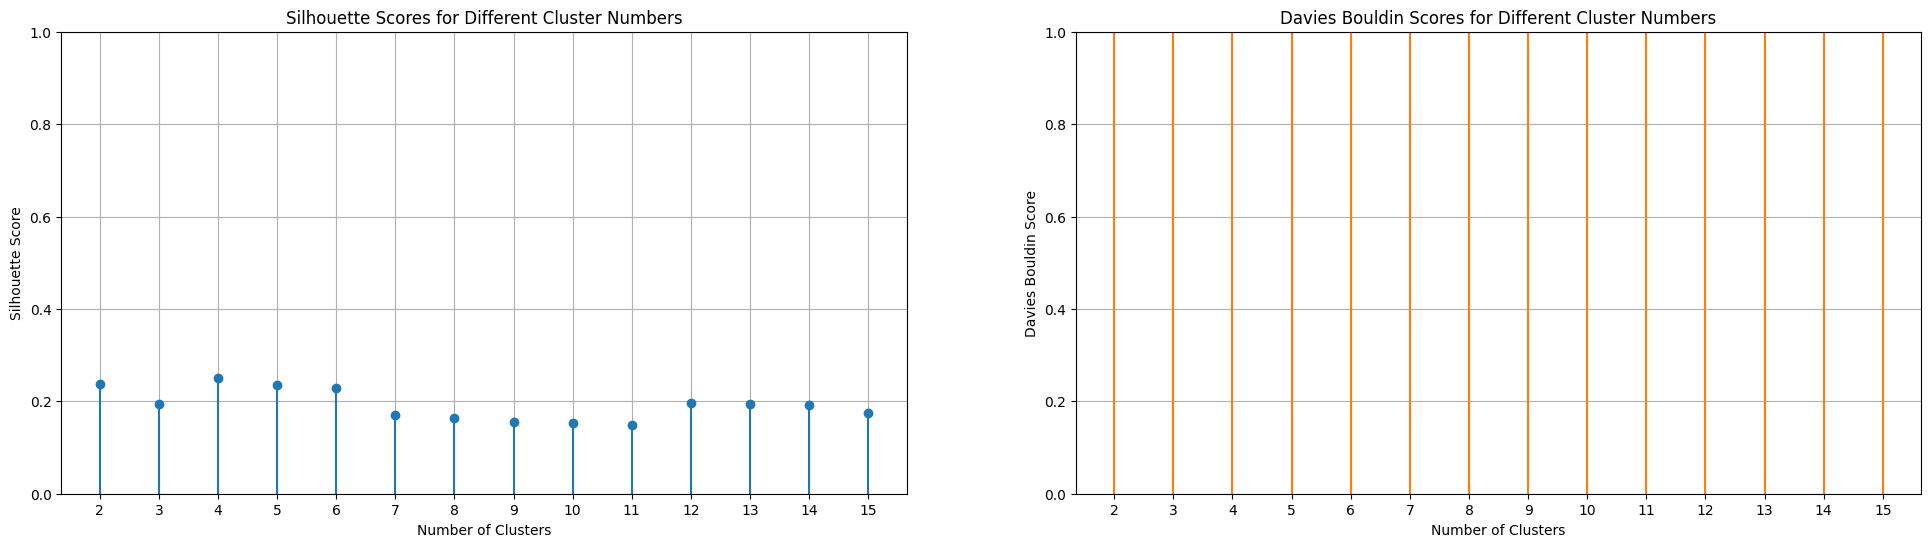

--- Metric: manhattan
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.29 for 2 clusters
Best score for Davies Bouldin metric: 1.08 for 2 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



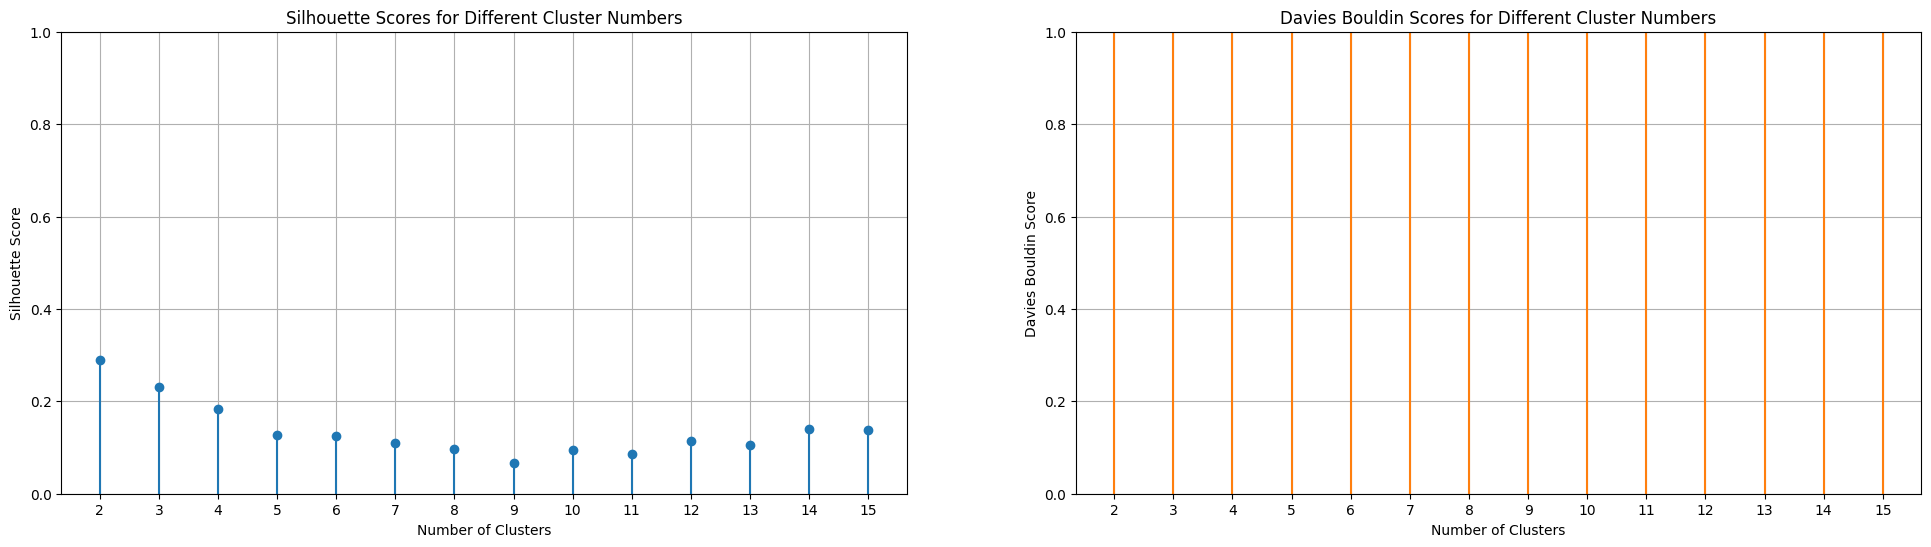

--- Metric: cosine
--- Linkage: average
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.43 for 3 clusters
Best score for Davies Bouldin metric: 1.56 for 14 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



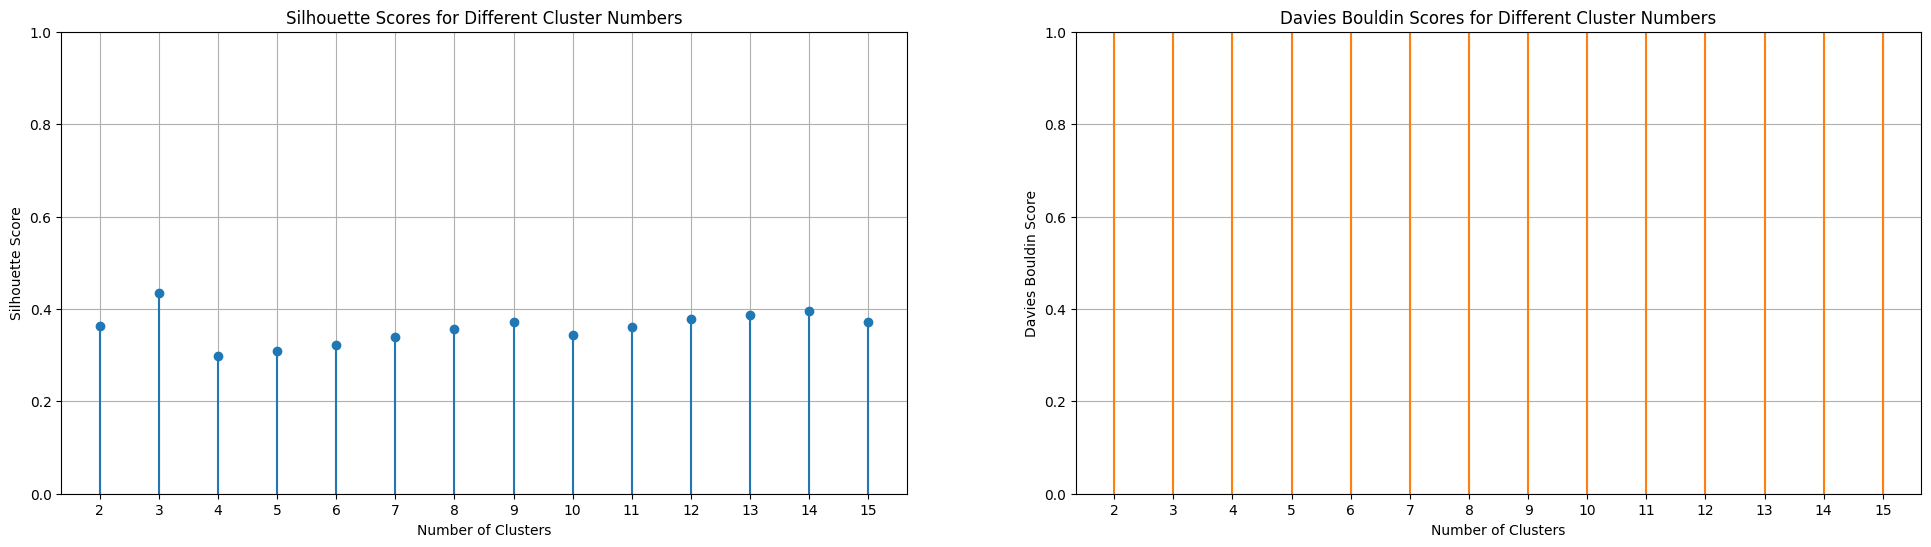

--- Metric: l1
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.35 for 2 clusters
Best score for Davies Bouldin metric: 0.51 for 2 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



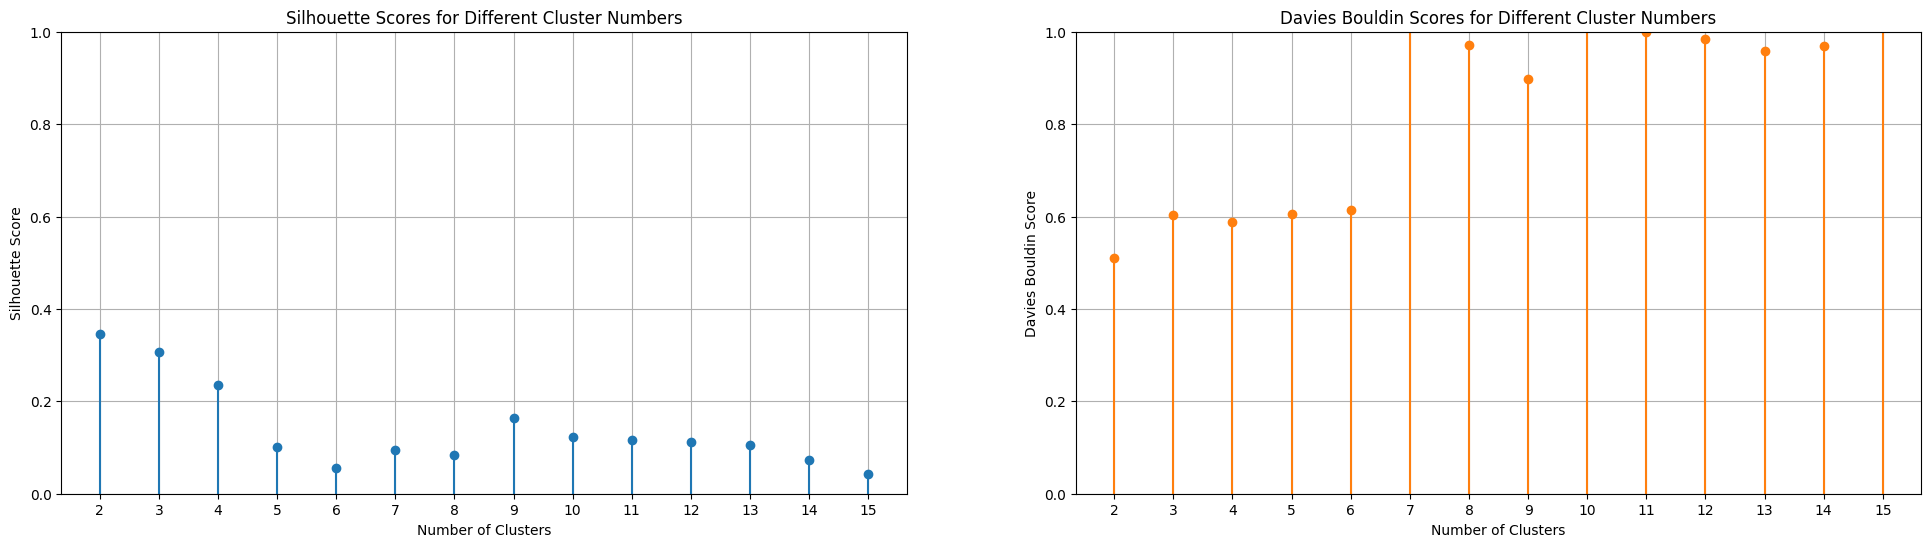

--- Metric: l2
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.26 for 2 clusters
Best score for Davies Bouldin metric: 0.96 for 9 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



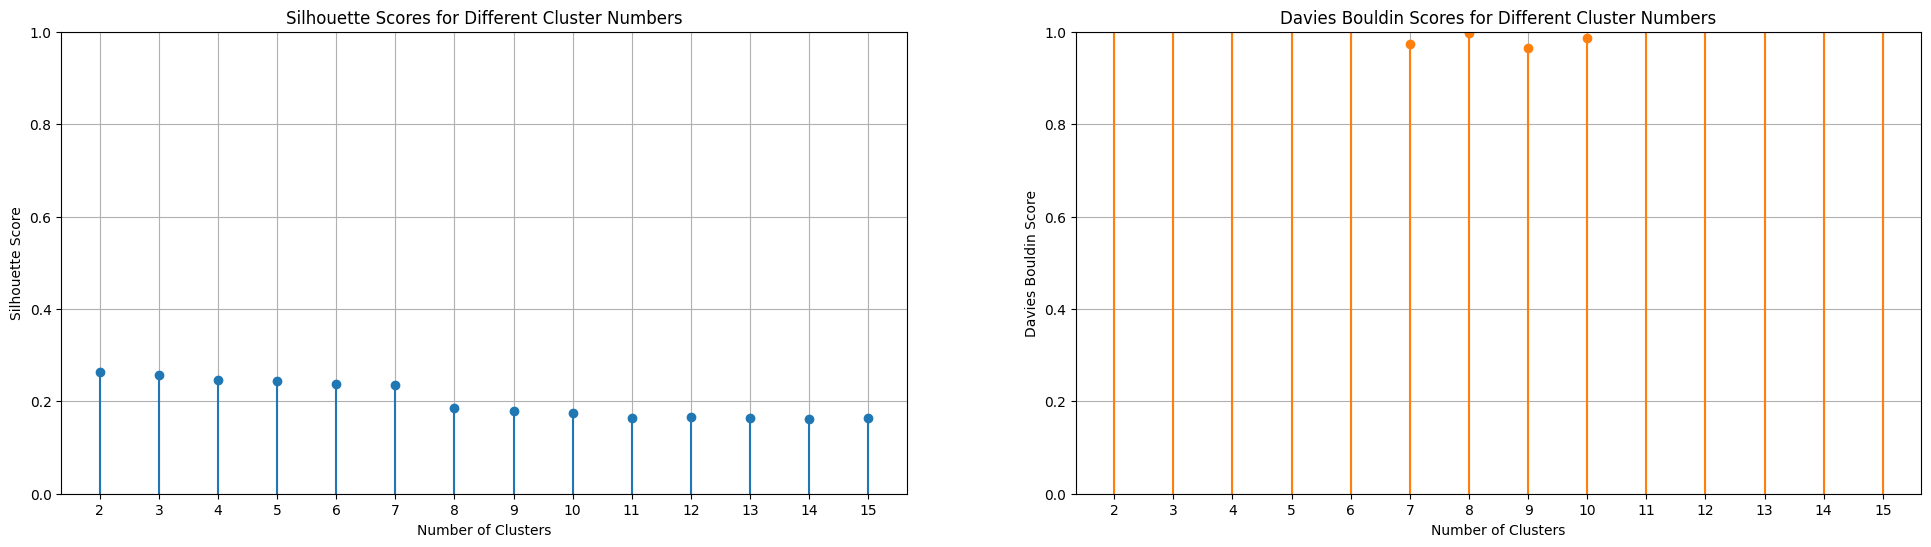

--- Metric: manhattan
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.35 for 2 clusters
Best score for Davies Bouldin metric: 0.51 for 2 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



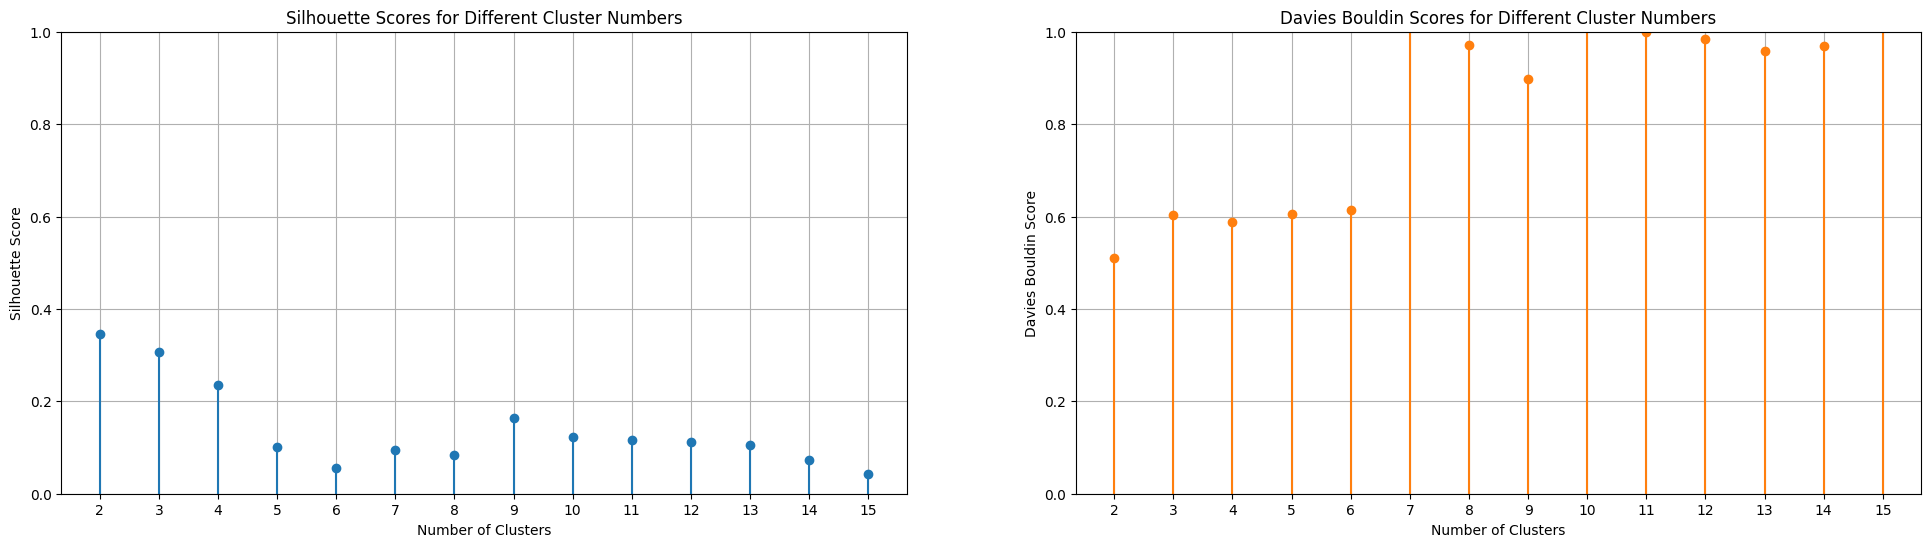

--- Metric: cosine
--- Linkage: single
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.43 for 3 clusters
Best score for Davies Bouldin metric: 1.39 for 15 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



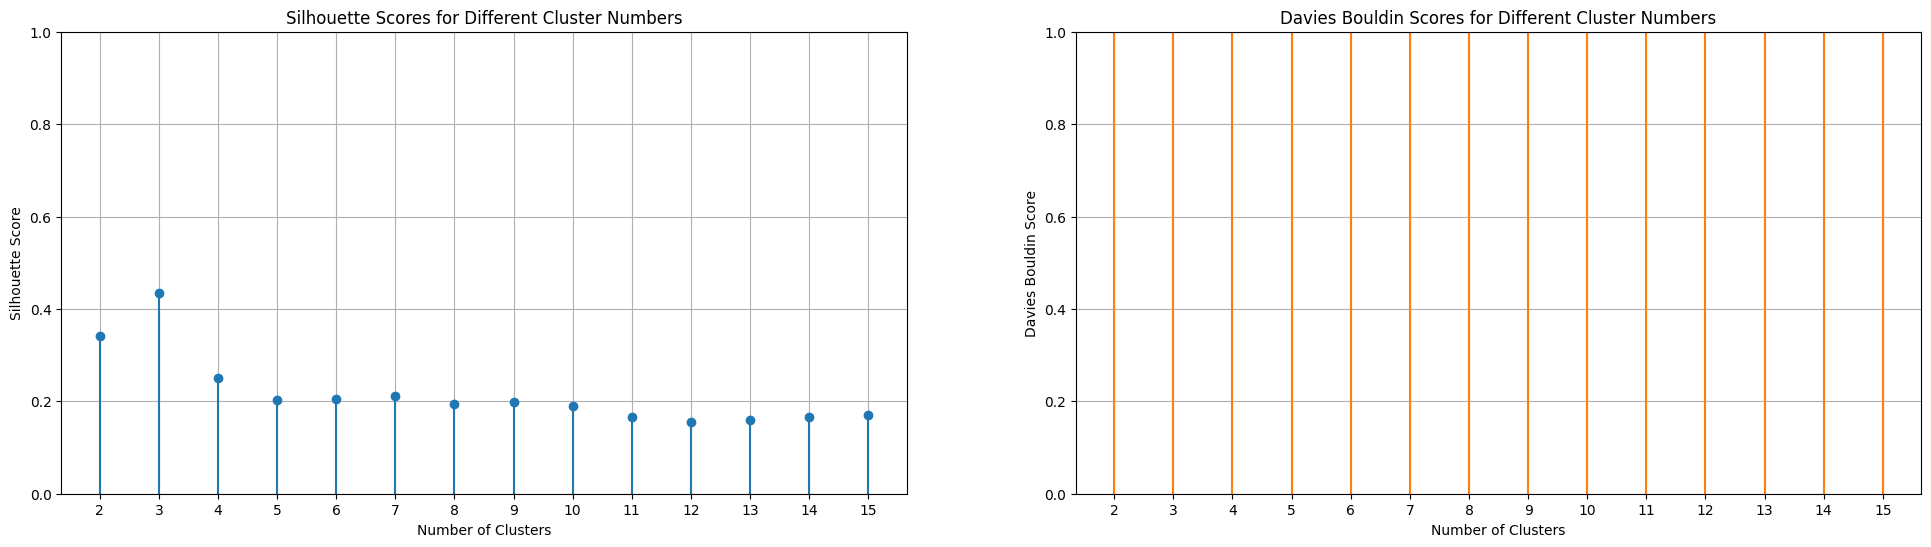

--- Metric: Euclidean
--- Linkage: Ward
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: agglomerative##########
Best score for Silhouette metric: 0.43 for 3 clusters
Best score for Davies Bouldin metric: 1.40 for 14 clusters

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



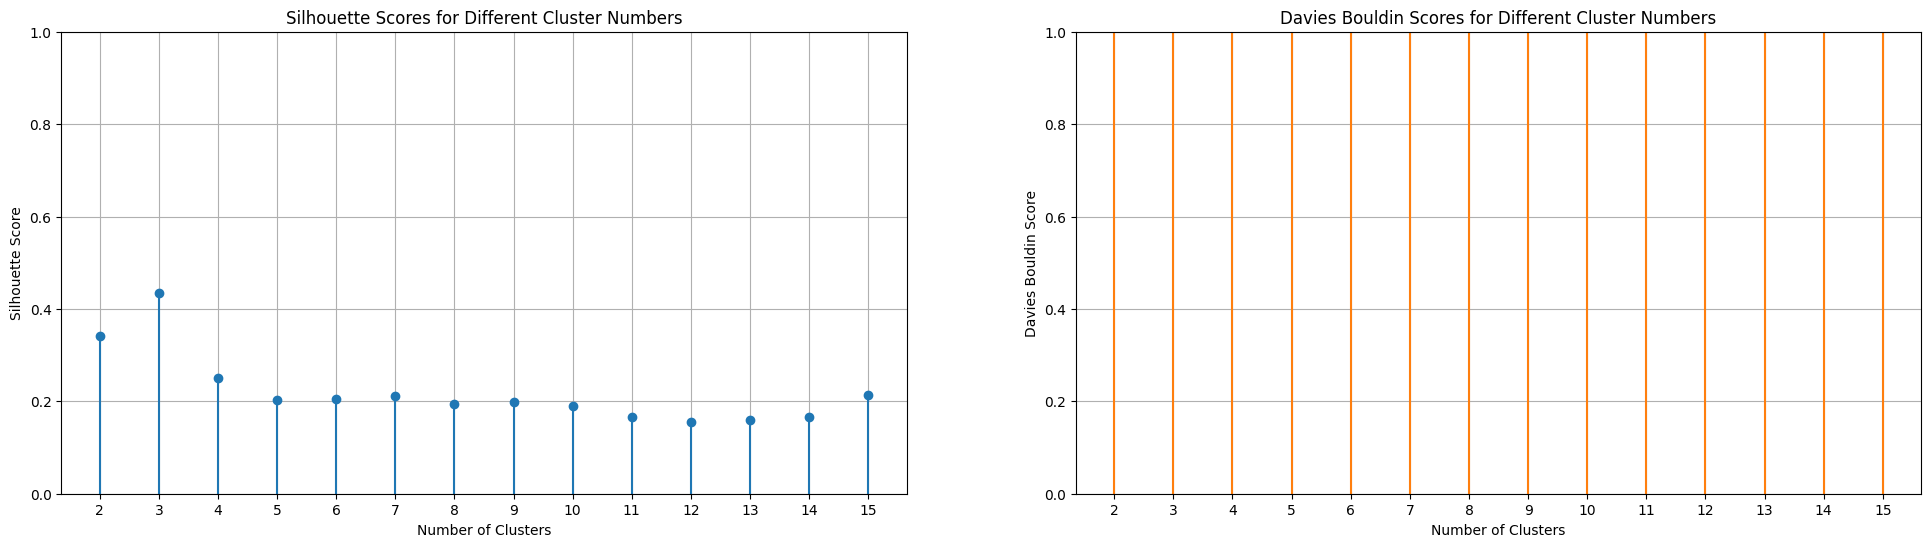

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

########## Metrics best performance for different clusters - Algorithm: dbscan##########
Best score for Silhouette metric: 0.08 for 2 clusters
Best score for Davies Bouldin metric: 1.12 for 2 clusters

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------



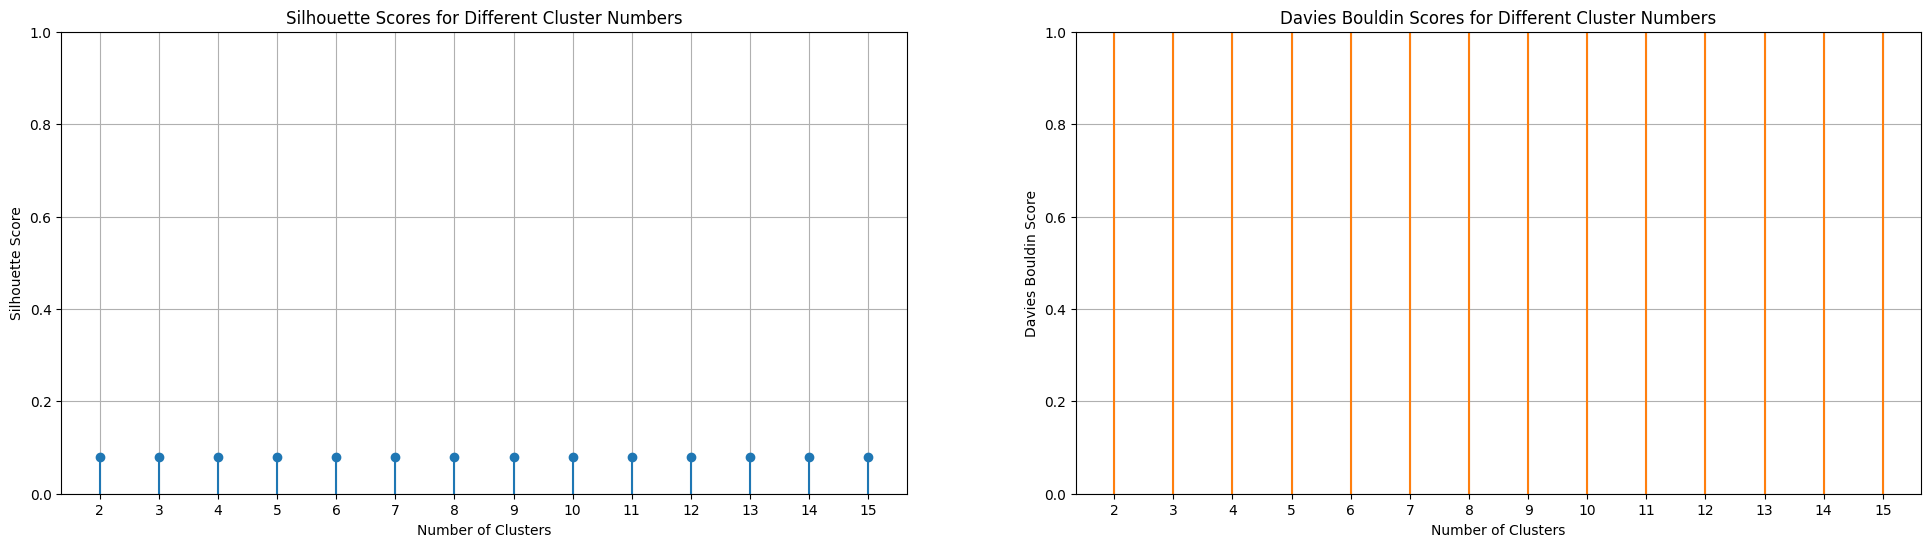

In [ ]:
min_clusters = 2
max_clusters = 15

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for algorithm in ['k-means', 'mini-batch', 'agglomerative', 'dbscan']:

  if algorithm == 'agglomerative':
    for linkage in ['complete', 'average', 'single']:
      for metric in ['l1', 'l2', 'manhattan','cosine']:
        for n_clusters in clusters:
          s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_clustering(X_pca, n_clusters, algorithm = algorithm, metric = metric, linkage = linkage)
        print(f'--- Metric: {metric}')
        print(f'--- Linkage: {linkage}')
        visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm)
    print('--- Metric: Euclidean')
    print('--- Linkage: Ward')
    s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_clustering(X_pca, n_clusters, algorithm = algorithm, metric = 'euclidean', linkage = 'ward')
    visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm)

  else:
    for n_clusters in clusters:
      s_scores[n_clusters-2], dbs_scores[n_clusters-2] =  evaluate_clustering(X_pca, n_clusters, algorithm = algorithm)
    visualize_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, algorithm)

## 4.4 - Fit test

In [ ]:
from IPython.display import display

def model_validation(df, X, n_clusters = 2, algorithm = 'k-means', metric = 'euclidean', linkage = 'ward'):

  if algorithm == 'k-means':
      model = kmeans_clustering(X, n_clusters)
  elif algorithm == 'mini-batch':
      model = minibatch_kmeans_clustering(X, n_clusters)
  elif algorithm == 'dbscan':
      model = dbscan_clustering(X)
  elif algorithm == 'agglomerative':
      model = agglomerative_clustering(X, n_clusters, metric = metric, linkage = linkage)


  labels  = model.fit_predict(X)

  return labels

In [ ]:
import plotly.express as px

def visu_clusters(df, x1, x2, labels):
    fig = px.scatter(df, x=df[x1].astype('string'), y=df[x2], color=labels)
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(
        title=f'Scatter plot of {x1} over {x2}',
        xaxis_title=x1,
        yaxis_title=x2,
        legend_title="Categories",
        xaxis_tickangle=90,
        showlegend=True
    )
    fig.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def visu_clusters_3d(df1, df2, df3, df4, x1, x2, labels1, labels2, labels3, labels4):
    fig = plt.figure(figsize=(24, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for Hospital 1
    ax.scatter(df1[x1].astype('string'), np.ones(len(df1)), df1[x2], c=labels1, s=5, cmap='rainbow')

    # Scatter plot for Hospital 2
    ax.scatter(df2[x1].astype('string'), 2 * np.ones(len(df2)), df2[x2], c=labels2, s=5, cmap='rainbow')

    # Scatter plot for Hospital 3
    ax.scatter(df3[x1].astype('string'), 3 * np.ones(len(df3)), df3[x2], c=labels3, s=5, cmap='rainbow')

    # Scatter plot for Hospital 4
    ax.scatter(df4[x1].astype('string'), 4 * np.ones(len(df4)), df4[x2], c=labels4, s=5, cmap='rainbow')

    # Set labels and title
    ax.set_xlabel(x1)
    ax.set_ylabel('Hospital')
    ax.set_zlabel(x2)
    ax.set_title('3D Scatter Plot')

    # Set y-ticks and labels for hospitals
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(['Hospital 1', 'Hospital 2', 'Hospital 3', 'Hospital 4'])

    # Increase space between ticks and axis label
    ax.tick_params(axis='x', rotation=90, pad=10)
    ax.tick_params(axis='y', pad=10)

    # Show the plot
    plt.show()


In [1]:
labels = model_validation(df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy(),
                             X,
                             n_clusters = 15, algorithm = 'agglomerative', metric = 'manhattan', linkage = 'average')

visu_clusters(df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy(),
              'HOSPI_CODE_UCD', 'QUANTITY',
              ['cat_' + str(s) for s in labels])

NameError: ignored

In [ ]:
labels_pca = model_validation(df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy(),
                             X_pca,
                             n_clusters = 6, algorithm = 'agglomerative', metric = 'cosine', linkage = 'average')

visu_clusters(df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy(),
              'HOSPI_CODE_UCD', 'QUANTITY',
              ['cat_' + str(s) for s in labels_pca])

### Saving the datasets with clusters

In [ ]:
df_clustered = df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy()
df_clustered['CLUSTER'] = labels

flag = True
for cluster in df_clustered.CLUSTER.unique():
  for medicine in df_clustered[df_clustered['CLUSTER'] == cluster]['HOSPI_CODE_UCD'].unique():
    data_points = len(df_clustered[(df_clustered['CLUSTER'] == cluster) & (df_clustered['HOSPI_CODE_UCD'] == medicine)].values)
    if data_points < 4:
      print(cluster)
      print(medicine)


      flag = False
      print('The cluster has less than one sample of the medicine')
if flag:
  print('OK')



OK


In [ ]:
df_clustered_pca = df[df['HOSPI_CODE_UCD']!= '3400891996128'].copy()
df_clustered_pca['CLUSTER'] = labels_pca

flag = True
for cluster in df_clustered_pca.CLUSTER.unique():
  for medicine in df_clustered_pca[df_clustered_pca['CLUSTER'] == cluster]['HOSPI_CODE_UCD'].unique():
    data_points = len(df_clustered_pca[(df_clustered_pca['CLUSTER'] == cluster) & (df_clustered_pca['HOSPI_CODE_UCD'] == medicine)].values)
    if data_points == 1:
      print(cluster)
      print(medicine)

      flag = False
      print('The cluster has just one sample of the medicine')
if flag:
  print('OK')



OK


In [ ]:
df_clustered.to_csv('df_clustered.csv', index=False)
df_clustered_pca.to_csv('df_clustered_pca.csv', index = False)